<a href="https://colab.research.google.com/github/elateifsara/MLxDays/blob/master/V2_WiDS_Datathon_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tutorial link: https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8

# Loading the data from kaggle

In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!touch '/root/.kaggle/kaggle.json'
import json
############################ #################### 
# IMPORTANT 
# Copy the contents of your file kaggle.json to the following line 
api_token = {"username":"easara","key":"dc4b257c16ed4dad0007a0f9285f1391"}
#############################################
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.kaggle/kaggle.json

In [2]:
!kaggle competitions download -c widsdatathon2020

  0% 0.00/313k [00:00<?, ?B/s]
100% 313k/313k [00:00<00:00, 92.1MB/s]
  0% 0.00/52.0 [00:00<?, ?B/s]
100% 52.0/52.0 [00:00<00:00, 45.8kB/s]
 70% 11.0M/15.7M [00:00<00:00, 26.5MB/s]
100% 15.7M/15.7M [00:00<00:00, 39.8MB/s]
 72% 5.00M/6.93M [00:00<00:00, 22.2MB/s]
100% 6.93M/6.93M [00:00<00:00, 27.4MB/s]
  0% 0.00/29.2k [00:00<?, ?B/s]
100% 29.2k/29.2k [00:00<00:00, 75.0MB/s]


In [3]:
!unzip training_v2.csv.zip 
!unzip unlabeled.csv.zip

Archive:  training_v2.csv.zip
  inflating: training_v2.csv         
Archive:  unlabeled.csv.zip
  inflating: unlabeled.csv           


In [4]:
!ls

sample_data	       training_v2.csv.zip
samplesubmission.csv   unlabeled.csv
solution_template.csv  unlabeled.csv.zip
training_v2.csv        WiDS%20Datathon%202020%20Dictionary.csv


# Importing the Libraries

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

# Getting the data

In [0]:
train_df = pd.read_csv("training_v2.csv")
test_df = pd.read_csv("unlabeled.csv")

# Data Exploration/Analysis

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Columns: 186 entries, encounter_id to apache_2_bodysystem
dtypes: float64(170), int64(8), object(8)
memory usage: 130.1+ MB


Training set has:
- 91713 examples
- 186 columns (185 features + hospital_death as target): 
    - 8 Categorical variables
    - 8 int64
    - 170 float63

In [8]:
train_df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,...,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0.0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,70.2,NaN,108.0,203.01,0,0.0,NaN,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0.0,46.0,37.0,37.0,51.0,7.45,...,1.3,1.3,3.5,3.5,557.0,557.0,4.2,4.2,145.0,145.0,12.7,12.7,37.0,37.0,7.45,7.45,51.0,51.0,54.8,51.000000,37.0,37.0,7.45,7.45,51.0,51.0,51.0,51.0,0.47,0.29,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,Emergency Department,Accident & Emergency,93,admit,Med-Surg ICU,0.000694,0,95.3,NaN,122.0,703.03,0,0.0,NaN,NaN,NaN,NaN,3.0,6.0,0.0,5.0,NaN,102.0,NaN,0.0,68.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,Operating Room,Operating Room / Recovery,92,admit,CTICU,0.000694,0,61.7,NaN,203.0,1206.03,1,0.0,NaN,NaN,NaN,0.6,4.0,6.0,0.0,5.0,185.0,114.0,25.9,1.0,60.0,30.0,30.0,142.0,7.39,...,1.6,1.1,NaN,NaN,43.0,43.0,NaN,NaN,NaN,NaN,8.8,8.8,37.0,27.0,7.44,7.34,337.0,102.0,342.5,236.666667,36.0,33.0,7.37,7.34,337.0,265.0,337.0,337.0,0.04,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,NaN,Accident & Emergency,91,admit,Med-Surg ICU,0.073611,0,NaN,NaN,119.0,601.01,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,0.0,103.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [9]:
# The dictionary defining our columns
df_dictionary = pd.read_csv('WiDS%20Datathon%202020%20Dictionary.csv')
print("Dimension : ", df_dictionary.shape)
df_dictionary[['Category', 'Variable Name', 'Description']].head()

Dimension :  (188, 6)


,Category,Variable Name,Description
0,identifier,encounter_id,Unique identifier associated with a patient un...
1,identifier,hospital_id,Unique identifier associated with a hospital
2,identifier,patient_id,Unique identifier associated with a patient
3,demographic,hospital_death,Whether the patient died during this hospitali...
4,demographic,age,The age of the patient on unit admission


It's best to check the "WiDS Datathon 2020 Dictionary.csv" thoroughtly and read the Description column very well.   
Please check my side comments.

In [10]:
train_df.describe()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,...,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
count,91713.000000,91713.000000,91713.000000,91713.000000,87485.000000,88284.000000,91713.000000,90379.000000,91713.000000,91713.000000,91713.0,88993.000000,37334.000000,90051.000000,90612.000000,91713.000000,90998.000000,33579.000000,72451.00000,72860.000000,20845.000000,89812.000000,89812.000000,90676.000000,89812.000000,80677.000000,90835.000000,71835.000000,90998.000000,90719.000000,20845.000000,20845.000000,20845.000000,20845.000000,90479.000000,73113.000000,87605.000000,42715.000000,90998.000000,69701.000000,...,18293.000000,18293.000000,33772.000000,33772.000000,7344.000000,7344.000000,16040.000000,16040.000000,19611.000000,19611.000000,19096.000000,19096.000000,15760.000000,15760.000000,32442.000000,32442.000000,31590.000000,31590.000000,32451.000000,32451.000000,25705.000000,25705.000000,15754.000000,15754.000000,15289.000000,15289.000000,15768.000000,15768.000000,11518.000000,11518.000000,83766.000000,83766.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000
mean,65606.079280,65537.131464,105.669262,0.086302,62.309516,29.185818,0.183736,169.641588,508.357692,0.835766,0.0,84.028340,2.902968,185.401739,558.216377,0.201106,0.027979,1.147721,25.82533,1.480014,0.595751,3.465049,5.471195,0.009528,3.994778,160.326822,99.707932,32.988739,0.151223,88.015873,42.183238,42.183238,131.148467,7.353895,25.811007,137.966373,36.414472,1738.276831,0.325721,12.133333,...,33.673673,33.223156,1.596476,1.482979,3.068860,3.021543,196.096010,195.481546,4.201144,4.153006,138.239610,137.901948,13.460212,13.423475,45.248924,38.433862,7.389236,7.324530,165.913980,103.511349,285.667079,223.523037,44.668444,43.383453,7.338363,7.327883,163.841354,144.154224,244.404982,235.933050,0.086787,0.043955,0.000857,0.015693,0.225192,0.012989,0.026165,0.007066,0.004132,0.020638
std,37795.088538,37811.252183,62.854406,0.280811,16.775119,8.275142,0.387271,10.795378,228.989661,2.487756,0.0,25.011497,0.681863,86.050882,463.266985,0.400829,0.164912,2.165538,20.67298,1.525787,0.263238,0.951715,1.288376,0.097148,1.560166,90.790551,30.870502,6.873585,0.358268,42.032412,12.382412,12.382412,83.607292,0.097755,15.106312,5.279418,0.833496,1448.162411,0.468646,6.917984,...,6.840011,7.029452,0.955843,0.748557,2.926545,2.884303,92.646583,92.779494,0.763201,0.752529,5.745875,5.676796,6.979339,6.965104,14.669776,10.944916,0.084735,0.111561,108.005939,61.848052,128.218956,117.552497,14.630907,14.113107,0.105821,0.107873,113.455738,98.464543,129.964308,126.458507,0.247569,0.217341,0.029265,0.124284,0.417711,0.113229,0.159628,0.083763,0.064148,0.142169
min,1.000000,1.000000,2.000000,0.000000,16.000000,14.844926,0.000000,137.200000,82.000000,-24.947222,0.0,38.600000,1.200

We can see that 8% out of th training set died. We can also see that the mean age of patients is 62 and ranges from 16 until 89.

We can note a few things, from the above tables. First of all, that we need to convert a lot of features into numeric ones later on, so that the machine learning algorithms can process them. Furthermore, we can see that the features have widely different ranges, that we will need to convert into roughly the same scale. We can also spot some more features, that contain missing values (NaN = not a number) like : weight and	albumin_apache, that wee need to deal with.

Let’s take a more detailed look at what data is actually missing:

In [11]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


,Total,%
age,4228,4.6
aids,715,0.8
albumin_apache,54379,59.3
apache_2_bodysystem,1662,1.8
apache_2_diagnosis,1662,1.8


This is quite troublesome we have a lot of missing values especially for the albumin_apache column that exceeds 50%. We may have to drop it but we will see if there's a way to deal with it.

Dealing with missing values:
- age : we could impute using mean
- aids: (binary) most common
- albumin_apache: numeric column, sadly doesn't look like we should drop it. Leave until last.
- apache_2_bodysystem: string (categorical variable) we could encode using some kind of correspendence between numbers and category.
- apache_2_diagnosis: (string) but it has numbers, need to look more into it.

Let's study relationships between these features and our target variable hospital_death.

## Age and Gender

In [0]:
%matplotlib inline

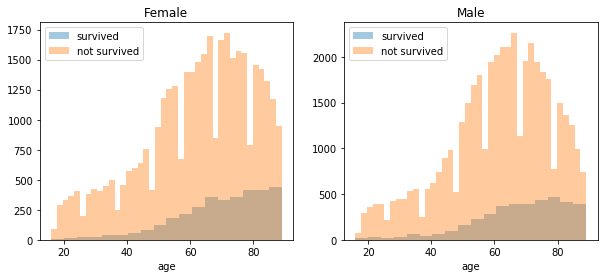

In [13]:
survived = 'survived'
not_survived = 'not survived'

women = train_df[train_df['gender']=='F']
men = train_df[train_df['gender']=='M']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ax = sns.distplot(women[women['hospital_death']==1].age.dropna(),
                 bins=18, label=survived, ax=axes[0], kde=False)
ax = sns.distplot(women[women['hospital_death']==0].age.dropna(),
                 bins=40, label=not_survived, ax=axes[0], kde=False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['hospital_death']==1].age.dropna(), bins=18, label=survived, ax=axes[1], kde=False)
ax = sns.distplot(men[men['hospital_death']==0].age.dropna(), bins=40, label=not_survived, ax=axes[1], kde=False)
ax .legend()
_ = ax.set_title('Male')

It seems that men are more affected than women, and for both genders we have ahigh rate of hospital death from 50 until 77 and drops a bit around 80 and above. Roughtly we can say that from 50 until 80 a person is highly likely to die but then we should still consider other factors that affects ones health.

As for people from 20 to 50 they have a good chance to stay alive.

Since there seem to be certain ages, which have increased odds of survival and because I want every feature to be roughly on the same scale, I will create age groups later on.

## APACHE

In [0]:
import plotly.express as px

In [15]:
#@title Histograme { run: "auto", form-width: "50%" }
histograme_variable = "apache_3j_bodysystem" #@param ['encounter_id', 'patient_id', 'hospital_id', 'hospital_death', 'age', 'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height', 'hospital_admit_source', 'icu_admit_source', 'icu_id', 'icu_stay_type', 'icu_type', 'pre_icu_los_days', 'readmission_status', 'weight', 'albumin_apache', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache', 'bilirubin_apache', 'bun_apache', 'creatinine_apache', 'fio2_apache', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache', 'glucose_apache', 'heart_rate_apache', 'hematocrit_apache', 'intubated_apache', 'map_apache', 'paco2_apache', 'paco2_for_ph_apache', 'pao2_apache', 'ph_apache', 'resprate_apache', 'sodium_apache', 'temp_apache', 'urineoutput_apache', 'ventilated_apache', 'wbc_apache', 'd1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_invasive_max', 'd1_mbp_invasive_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_invasive_max', 'd1_sysbp_invasive_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max', 'd1_temp_min', 'h1_diasbp_invasive_max', 'h1_diasbp_invasive_min', 'h1_diasbp_max', 'h1_diasbp_min', 'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min', 'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_invasive_max', 'h1_mbp_invasive_min', 'h1_mbp_max', 'h1_mbp_min', 'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_resprate_max', 'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_min', 'h1_sysbp_invasive_max', 'h1_sysbp_invasive_min', 'h1_sysbp_max', 'h1_sysbp_min', 'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min', 'h1_temp_max', 'h1_temp_min', 'd1_albumin_max', 'd1_albumin_min', 'd1_bilirubin_max', 'd1_bilirubin_min', 'd1_bun_max', 'd1_bun_min', 'd1_calcium_max', 'd1_calcium_min', 'd1_creatinine_max', 'd1_creatinine_min', 'd1_glucose_max', 'd1_glucose_min', 'd1_hco3_max', 'd1_hco3_min', 'd1_hemaglobin_max', 'd1_hemaglobin_min', 'd1_hematocrit_max', 'd1_hematocrit_min', 'd1_inr_max', 'd1_inr_min', 'd1_lactate_max', 'd1_lactate_min', 'd1_platelets_max', 'd1_platelets_min', 'd1_potassium_max', 'd1_potassium_min', 'd1_sodium_max', 'd1_sodium_min', 'd1_wbc_max', 'd1_wbc_min', 'h1_albumin_max', 'h1_albumin_min', 'h1_bilirubin_max', 'h1_bilirubin_min', 'h1_bun_max', 'h1_bun_min', 'h1_calcium_max', 'h1_calcium_min', 'h1_creatinine_max', 'h1_creatinine_min', 'h1_glucose_max', 'h1_glucose_min', 'h1_hco3_max', 'h1_hco3_min', 'h1_hemaglobin_max', 'h1_hemaglobin_min', 'h1_hematocrit_max', 'h1_hematocrit_min', 'h1_inr_max', 'h1_inr_min', 'h1_lactate_max', 'h1_lactate_min', 'h1_platelets_max', 'h1_platelets_min', 'h1_potassium_max', 'h1_potassium_min', 'h1_sodium_max', 'h1_sodium_min', 'h1_wbc_max', 'h1_wbc_min', 'd1_arterial_pco2_max', 'd1_arterial_pco2_min', 'd1_arterial_ph_max', 'd1_arterial_ph_min', 'd1_arterial_po2_max', 'd1_arterial_po2_min', 'd1_pao2fio2ratio_max', 'd1_pao2fio2ratio_min', 'h1_arterial_pco2_max', 'h1_arterial_pco2_min', 'h1_arterial_ph_max', 'h1_arterial_ph_min', 'h1_arterial_po2_max', 'h1_arterial_po2_min', 'h1_pao2fio2ratio_max', 'h1_pao2fio2ratio_min', 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', 'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis', 'apache_3j_bodysystem', 'apache_2_bodysystem']
hospital_death = "1" #@param ["All", "0", "1"]

# We filter the dataset according to the option selected.
if hospital_death == '0':
  df = train_df[train_df['hospital_death'] == 0]
elif hospital_death=='1':
  df = train_df[train_df['hospital_death'] == 1]  
else:
  df = train_df.copy()


px.histogram(df, x=histograme_variable, title=histograme_variable + ', Hospital_death (' + hospital_death + ')')


It seems that people who suffers from **cardiovascular, sepsis, respiratory and neurological** symptoms have a high possibility to die. There's also Gastrointestinal that we could worry about but its not as worrying as the others.

In [16]:
#@title Histograme { run: "auto", form-width: "50%" }
histograme_variable = "apache_2_bodysystem" #@param ['encounter_id', 'patient_id', 'hospital_id', 'hospital_death', 'age', 'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height', 'hospital_admit_source', 'icu_admit_source', 'icu_id', 'icu_stay_type', 'icu_type', 'pre_icu_los_days', 'readmission_status', 'weight', 'albumin_apache', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache', 'bilirubin_apache', 'bun_apache', 'creatinine_apache', 'fio2_apache', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache', 'glucose_apache', 'heart_rate_apache', 'hematocrit_apache', 'intubated_apache', 'map_apache', 'paco2_apache', 'paco2_for_ph_apache', 'pao2_apache', 'ph_apache', 'resprate_apache', 'sodium_apache', 'temp_apache', 'urineoutput_apache', 'ventilated_apache', 'wbc_apache', 'd1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_invasive_max', 'd1_mbp_invasive_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_invasive_max', 'd1_sysbp_invasive_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max', 'd1_temp_min', 'h1_diasbp_invasive_max', 'h1_diasbp_invasive_min', 'h1_diasbp_max', 'h1_diasbp_min', 'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min', 'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_invasive_max', 'h1_mbp_invasive_min', 'h1_mbp_max', 'h1_mbp_min', 'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_resprate_max', 'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_min', 'h1_sysbp_invasive_max', 'h1_sysbp_invasive_min', 'h1_sysbp_max', 'h1_sysbp_min', 'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min', 'h1_temp_max', 'h1_temp_min', 'd1_albumin_max', 'd1_albumin_min', 'd1_bilirubin_max', 'd1_bilirubin_min', 'd1_bun_max', 'd1_bun_min', 'd1_calcium_max', 'd1_calcium_min', 'd1_creatinine_max', 'd1_creatinine_min', 'd1_glucose_max', 'd1_glucose_min', 'd1_hco3_max', 'd1_hco3_min', 'd1_hemaglobin_max', 'd1_hemaglobin_min', 'd1_hematocrit_max', 'd1_hematocrit_min', 'd1_inr_max', 'd1_inr_min', 'd1_lactate_max', 'd1_lactate_min', 'd1_platelets_max', 'd1_platelets_min', 'd1_potassium_max', 'd1_potassium_min', 'd1_sodium_max', 'd1_sodium_min', 'd1_wbc_max', 'd1_wbc_min', 'h1_albumin_max', 'h1_albumin_min', 'h1_bilirubin_max', 'h1_bilirubin_min', 'h1_bun_max', 'h1_bun_min', 'h1_calcium_max', 'h1_calcium_min', 'h1_creatinine_max', 'h1_creatinine_min', 'h1_glucose_max', 'h1_glucose_min', 'h1_hco3_max', 'h1_hco3_min', 'h1_hemaglobin_max', 'h1_hemaglobin_min', 'h1_hematocrit_max', 'h1_hematocrit_min', 'h1_inr_max', 'h1_inr_min', 'h1_lactate_max', 'h1_lactate_min', 'h1_platelets_max', 'h1_platelets_min', 'h1_potassium_max', 'h1_potassium_min', 'h1_sodium_max', 'h1_sodium_min', 'h1_wbc_max', 'h1_wbc_min', 'd1_arterial_pco2_max', 'd1_arterial_pco2_min', 'd1_arterial_ph_max', 'd1_arterial_ph_min', 'd1_arterial_po2_max', 'd1_arterial_po2_min', 'd1_pao2fio2ratio_max', 'd1_pao2fio2ratio_min', 'h1_arterial_pco2_max', 'h1_arterial_pco2_min', 'h1_arterial_ph_max', 'h1_arterial_ph_min', 'h1_arterial_po2_max', 'h1_arterial_po2_min', 'h1_pao2fio2ratio_max', 'h1_pao2fio2ratio_min', 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', 'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis', 'apache_3j_bodysystem', 'apache_2_bodysystem']
hospital_death = "1" #@param ["All", "0", "1"]

# We filter the dataset according to the option selected.
if hospital_death == '0':
  df = train_df[train_df['hospital_death'] == 0]
elif hospital_death=='1':
  df = train_df[train_df['hospital_death'] == 1]  
else:
  df = train_df.copy()


px.histogram(df, x=histograme_variable, title=histograme_variable + ', Hospital_death (' + hospital_death + ')')

So Cardiovascular, Neurologic, Respiratory and Gastrointestinal are the most affecting according to apache2 bodysystem.

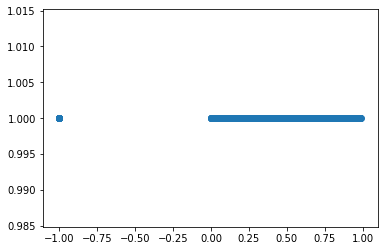

In [17]:
plt.scatter(x=df['apache_4a_hospital_death_prob'], y=df['hospital_death']);

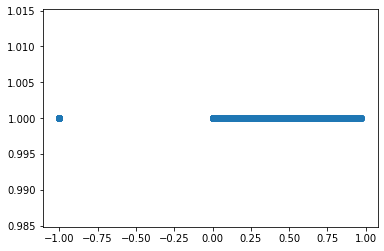

In [18]:
plt.scatter(x=df['apache_4a_icu_death_prob'], y=df['hospital_death']);

APACHE 4 type doesn't seem to be a good indicator.

## Diseases like leukemia and diabetes_mellitus

Let's see this columns effect on our traget variable:
- cirrhosis(heavy alcohol use), 
- diabetes_mellitus, 
- leukemia
- hepatic_failure: Whether the patient has cirrhosis and additional complications including jaundice and ascites, upper GI bleeding, hepatic encephalopathy, or coma.
- immunosuppression: Whether the patient has their immune system suppressed within six months prior to ICU admission for any of the following reasons; radiation therapy, chemotherapy, use of non-cytotoxic immunosuppressiv...
- lymphoma: Les lymphomes, comme les leucémies, font partie des hémopathies malignes.
- solid_tumor_with_metastasis

In [19]:
data2 = df[["cirrhosis", "diabetes_mellitus", "leukemia", "hepatic_failure", "immunosuppression", 
                               "lymphoma", "solid_tumor_with_metastasis"]]
data2.head()

,cirrhosis,diabetes_mellitus,leukemia,hepatic_failure,immunosuppression,lymphoma,solid_tumor_with_metastasis
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46,0.0,0.0,0.0,0.0,1.0,0.0,1.0
58,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73,0.0,1.0,1.0,0.0,0.0,0.0,0.0


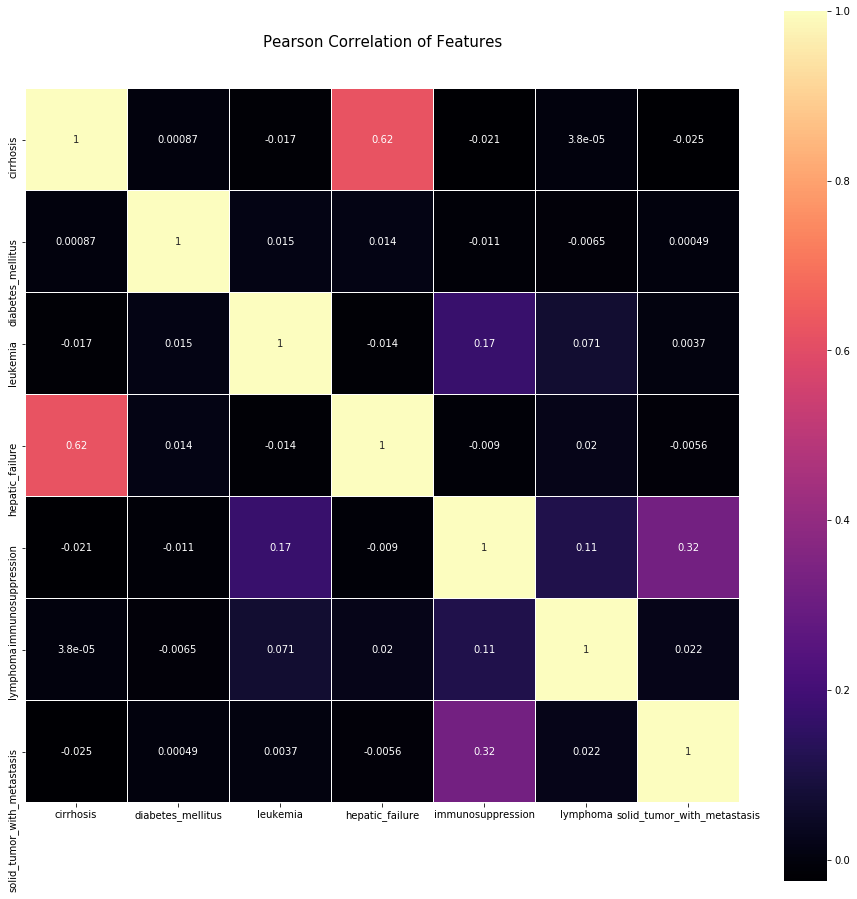

In [20]:
colormap = plt.cm.magma
plt.figure(figsize=(16,16))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(data2.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

There is an intersting correlation between **hepatic_failure** and **cirrhosis**.

In [21]:
data2 = df[["hospital_death", "cirrhosis", "diabetes_mellitus", "leukemia", "hepatic_failure", "immunosuppression", 
                               "lymphoma", "solid_tumor_with_metastasis"]]
data2.head()

,hospital_death,cirrhosis,diabetes_mellitus,leukemia,hepatic_failure,immunosuppression,lymphoma,solid_tumor_with_metastasis
8,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46,1,0.0,0.0,0.0,0.0,1.0,0.0,1.0
58,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [0]:
data = pd.DataFrame()

In [0]:
for column in ["cirrhosis", "diabetes_mellitus", "leukemia", "hepatic_failure", "immunosuppression", 
                               "lymphoma", "solid_tumor_with_metastasis"]:
  data[column] = data2.loc[(data2[column]==1.0) & (data2["hospital_death"]==1), column]

In [24]:
data.head()

,cirrhosis,diabetes_mellitus,leukemia,hepatic_failure,immunosuppression,lymphoma,solid_tumor_with_metastasis
691,1.0,1.0,NaN,1.0,NaN,NaN,NaN
1110,1.0,NaN,NaN,1.0,NaN,NaN,NaN
1207,1.0,NaN,NaN,1.0,NaN,NaN,NaN
2090,1.0,1.0,NaN,NaN,NaN,NaN,NaN
2362,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
total = data.sum().sort_values(ascending=False)
hd_deseases = pd.concat([total], axis=1, keys=['Total'])
hd_deseases.head()

,Total
cirrhosis,248.0
hepatic_failure,146.0
diabetes_mellitus,51.0
immunosuppression,6.0
solid_tumor_with_metastasis,4.0


Cirrhosis, hepatic failure and diabetes mellitus could be a major factor inducing death in these patients.

## Ethnicity

In [26]:
#@title Histograme { run: "auto", form-width: "50%" }
histograme_variable = "ethnicity" #@param ['encounter_id', 'patient_id', 'hospital_id', 'hospital_death', 'age', 'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height', 'hospital_admit_source', 'icu_admit_source', 'icu_id', 'icu_stay_type', 'icu_type', 'pre_icu_los_days', 'readmission_status', 'weight', 'albumin_apache', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache', 'bilirubin_apache', 'bun_apache', 'creatinine_apache', 'fio2_apache', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache', 'glucose_apache', 'heart_rate_apache', 'hematocrit_apache', 'intubated_apache', 'map_apache', 'paco2_apache', 'paco2_for_ph_apache', 'pao2_apache', 'ph_apache', 'resprate_apache', 'sodium_apache', 'temp_apache', 'urineoutput_apache', 'ventilated_apache', 'wbc_apache', 'd1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_invasive_max', 'd1_mbp_invasive_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_invasive_max', 'd1_sysbp_invasive_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max', 'd1_temp_min', 'h1_diasbp_invasive_max', 'h1_diasbp_invasive_min', 'h1_diasbp_max', 'h1_diasbp_min', 'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min', 'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_invasive_max', 'h1_mbp_invasive_min', 'h1_mbp_max', 'h1_mbp_min', 'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_resprate_max', 'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_min', 'h1_sysbp_invasive_max', 'h1_sysbp_invasive_min', 'h1_sysbp_max', 'h1_sysbp_min', 'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min', 'h1_temp_max', 'h1_temp_min', 'd1_albumin_max', 'd1_albumin_min', 'd1_bilirubin_max', 'd1_bilirubin_min', 'd1_bun_max', 'd1_bun_min', 'd1_calcium_max', 'd1_calcium_min', 'd1_creatinine_max', 'd1_creatinine_min', 'd1_glucose_max', 'd1_glucose_min', 'd1_hco3_max', 'd1_hco3_min', 'd1_hemaglobin_max', 'd1_hemaglobin_min', 'd1_hematocrit_max', 'd1_hematocrit_min', 'd1_inr_max', 'd1_inr_min', 'd1_lactate_max', 'd1_lactate_min', 'd1_platelets_max', 'd1_platelets_min', 'd1_potassium_max', 'd1_potassium_min', 'd1_sodium_max', 'd1_sodium_min', 'd1_wbc_max', 'd1_wbc_min', 'h1_albumin_max', 'h1_albumin_min', 'h1_bilirubin_max', 'h1_bilirubin_min', 'h1_bun_max', 'h1_bun_min', 'h1_calcium_max', 'h1_calcium_min', 'h1_creatinine_max', 'h1_creatinine_min', 'h1_glucose_max', 'h1_glucose_min', 'h1_hco3_max', 'h1_hco3_min', 'h1_hemaglobin_max', 'h1_hemaglobin_min', 'h1_hematocrit_max', 'h1_hematocrit_min', 'h1_inr_max', 'h1_inr_min', 'h1_lactate_max', 'h1_lactate_min', 'h1_platelets_max', 'h1_platelets_min', 'h1_potassium_max', 'h1_potassium_min', 'h1_sodium_max', 'h1_sodium_min', 'h1_wbc_max', 'h1_wbc_min', 'd1_arterial_pco2_max', 'd1_arterial_pco2_min', 'd1_arterial_ph_max', 'd1_arterial_ph_min', 'd1_arterial_po2_max', 'd1_arterial_po2_min', 'd1_pao2fio2ratio_max', 'd1_pao2fio2ratio_min', 'h1_arterial_pco2_max', 'h1_arterial_pco2_min', 'h1_arterial_ph_max', 'h1_arterial_ph_min', 'h1_arterial_po2_max', 'h1_arterial_po2_min', 'h1_pao2fio2ratio_max', 'h1_pao2fio2ratio_min', 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', 'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis', 'apache_3j_bodysystem', 'apache_2_bodysystem']
hospital_death = "1" #@param ["All", "0", "1"]

# We filter the dataset according to the option selected.
if hospital_death == '0':
  df = train_df[train_df['hospital_death'] == 0]
elif hospital_death=='1':
  df = train_df[train_df['hospital_death'] == 1]  
else:
  df = train_df.copy()


px.histogram(df, x=histograme_variable, title=histograme_variable + ', Hospital_death (' + hospital_death + ')')

The most affected by death are Caucasian people and some African American ones.

## Exploring the effect of some other features 

In [27]:
#@title Histograme { run: "auto", form-width: "50%" }
histograme_variable = "bmi" #@param ['encounter_id', 'patient_id', 'hospital_id', 'hospital_death', 'age', 'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height', 'hospital_admit_source', 'icu_admit_source', 'icu_id', 'icu_stay_type', 'icu_type', 'pre_icu_los_days', 'readmission_status', 'weight', 'albumin_apache', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache', 'bilirubin_apache', 'bun_apache', 'creatinine_apache', 'fio2_apache', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache', 'glucose_apache', 'heart_rate_apache', 'hematocrit_apache', 'intubated_apache', 'map_apache', 'paco2_apache', 'paco2_for_ph_apache', 'pao2_apache', 'ph_apache', 'resprate_apache', 'sodium_apache', 'temp_apache', 'urineoutput_apache', 'ventilated_apache', 'wbc_apache', 'd1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_invasive_max', 'd1_mbp_invasive_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_invasive_max', 'd1_sysbp_invasive_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max', 'd1_temp_min', 'h1_diasbp_invasive_max', 'h1_diasbp_invasive_min', 'h1_diasbp_max', 'h1_diasbp_min', 'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min', 'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_invasive_max', 'h1_mbp_invasive_min', 'h1_mbp_max', 'h1_mbp_min', 'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_resprate_max', 'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_min', 'h1_sysbp_invasive_max', 'h1_sysbp_invasive_min', 'h1_sysbp_max', 'h1_sysbp_min', 'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min', 'h1_temp_max', 'h1_temp_min', 'd1_albumin_max', 'd1_albumin_min', 'd1_bilirubin_max', 'd1_bilirubin_min', 'd1_bun_max', 'd1_bun_min', 'd1_calcium_max', 'd1_calcium_min', 'd1_creatinine_max', 'd1_creatinine_min', 'd1_glucose_max', 'd1_glucose_min', 'd1_hco3_max', 'd1_hco3_min', 'd1_hemaglobin_max', 'd1_hemaglobin_min', 'd1_hematocrit_max', 'd1_hematocrit_min', 'd1_inr_max', 'd1_inr_min', 'd1_lactate_max', 'd1_lactate_min', 'd1_platelets_max', 'd1_platelets_min', 'd1_potassium_max', 'd1_potassium_min', 'd1_sodium_max', 'd1_sodium_min', 'd1_wbc_max', 'd1_wbc_min', 'h1_albumin_max', 'h1_albumin_min', 'h1_bilirubin_max', 'h1_bilirubin_min', 'h1_bun_max', 'h1_bun_min', 'h1_calcium_max', 'h1_calcium_min', 'h1_creatinine_max', 'h1_creatinine_min', 'h1_glucose_max', 'h1_glucose_min', 'h1_hco3_max', 'h1_hco3_min', 'h1_hemaglobin_max', 'h1_hemaglobin_min', 'h1_hematocrit_max', 'h1_hematocrit_min', 'h1_inr_max', 'h1_inr_min', 'h1_lactate_max', 'h1_lactate_min', 'h1_platelets_max', 'h1_platelets_min', 'h1_potassium_max', 'h1_potassium_min', 'h1_sodium_max', 'h1_sodium_min', 'h1_wbc_max', 'h1_wbc_min', 'd1_arterial_pco2_max', 'd1_arterial_pco2_min', 'd1_arterial_ph_max', 'd1_arterial_ph_min', 'd1_arterial_po2_max', 'd1_arterial_po2_min', 'd1_pao2fio2ratio_max', 'd1_pao2fio2ratio_min', 'h1_arterial_pco2_max', 'h1_arterial_pco2_min', 'h1_arterial_ph_max', 'h1_arterial_ph_min', 'h1_arterial_po2_max', 'h1_arterial_po2_min', 'h1_pao2fio2ratio_max', 'h1_pao2fio2ratio_min', 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', 'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis', 'apache_3j_bodysystem', 'apache_2_bodysystem']
hospital_death = "1" #@param ["All", "0", "1"]

# We filter the dataset according to the option selected.
if hospital_death == '0':
  df = train_df[train_df['hospital_death'] == 0]
elif hospital_death=='1':
  df = train_df[train_df['hospital_death'] == 1]  
else:
  df = train_df.copy()


px.histogram(df, x=histograme_variable, title=histograme_variable + ', Hospital_death (' + hospital_death + ')')

People with a **bmi** < 40 seems to be most prone to a hospital death.

In [28]:
#@title Histograme { run: "auto", form-width: "50%" }
histograme_variable = "hospital_admit_source" #@param ['encounter_id', 'patient_id', 'hospital_id', 'hospital_death', 'age', 'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height', 'hospital_admit_source', 'icu_admit_source', 'icu_id', 'icu_stay_type', 'icu_type', 'pre_icu_los_days', 'readmission_status', 'weight', 'albumin_apache', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache', 'bilirubin_apache', 'bun_apache', 'creatinine_apache', 'fio2_apache', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache', 'glucose_apache', 'heart_rate_apache', 'hematocrit_apache', 'intubated_apache', 'map_apache', 'paco2_apache', 'paco2_for_ph_apache', 'pao2_apache', 'ph_apache', 'resprate_apache', 'sodium_apache', 'temp_apache', 'urineoutput_apache', 'ventilated_apache', 'wbc_apache', 'd1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_invasive_max', 'd1_mbp_invasive_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_invasive_max', 'd1_sysbp_invasive_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max', 'd1_temp_min', 'h1_diasbp_invasive_max', 'h1_diasbp_invasive_min', 'h1_diasbp_max', 'h1_diasbp_min', 'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min', 'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_invasive_max', 'h1_mbp_invasive_min', 'h1_mbp_max', 'h1_mbp_min', 'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_resprate_max', 'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_min', 'h1_sysbp_invasive_max', 'h1_sysbp_invasive_min', 'h1_sysbp_max', 'h1_sysbp_min', 'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min', 'h1_temp_max', 'h1_temp_min', 'd1_albumin_max', 'd1_albumin_min', 'd1_bilirubin_max', 'd1_bilirubin_min', 'd1_bun_max', 'd1_bun_min', 'd1_calcium_max', 'd1_calcium_min', 'd1_creatinine_max', 'd1_creatinine_min', 'd1_glucose_max', 'd1_glucose_min', 'd1_hco3_max', 'd1_hco3_min', 'd1_hemaglobin_max', 'd1_hemaglobin_min', 'd1_hematocrit_max', 'd1_hematocrit_min', 'd1_inr_max', 'd1_inr_min', 'd1_lactate_max', 'd1_lactate_min', 'd1_platelets_max', 'd1_platelets_min', 'd1_potassium_max', 'd1_potassium_min', 'd1_sodium_max', 'd1_sodium_min', 'd1_wbc_max', 'd1_wbc_min', 'h1_albumin_max', 'h1_albumin_min', 'h1_bilirubin_max', 'h1_bilirubin_min', 'h1_bun_max', 'h1_bun_min', 'h1_calcium_max', 'h1_calcium_min', 'h1_creatinine_max', 'h1_creatinine_min', 'h1_glucose_max', 'h1_glucose_min', 'h1_hco3_max', 'h1_hco3_min', 'h1_hemaglobin_max', 'h1_hemaglobin_min', 'h1_hematocrit_max', 'h1_hematocrit_min', 'h1_inr_max', 'h1_inr_min', 'h1_lactate_max', 'h1_lactate_min', 'h1_platelets_max', 'h1_platelets_min', 'h1_potassium_max', 'h1_potassium_min', 'h1_sodium_max', 'h1_sodium_min', 'h1_wbc_max', 'h1_wbc_min', 'd1_arterial_pco2_max', 'd1_arterial_pco2_min', 'd1_arterial_ph_max', 'd1_arterial_ph_min', 'd1_arterial_po2_max', 'd1_arterial_po2_min', 'd1_pao2fio2ratio_max', 'd1_pao2fio2ratio_min', 'h1_arterial_pco2_max', 'h1_arterial_pco2_min', 'h1_arterial_ph_max', 'h1_arterial_ph_min', 'h1_arterial_po2_max', 'h1_arterial_po2_min', 'h1_pao2fio2ratio_max', 'h1_pao2fio2ratio_min', 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', 'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis', 'apache_3j_bodysystem', 'apache_2_bodysystem']
hospital_death = "1" #@param ["All", "0", "1"]

# We filter the dataset according to the option selected.
if hospital_death == '0':
  df = train_df[train_df['hospital_death'] == 0]
elif hospital_death=='1':
  df = train_df[train_df['hospital_death'] == 1]  
else:
  df = train_df.copy()


px.histogram(df, x=histograme_variable, title=histograme_variable + ', Hospital_death (' + hospital_death + ')')

The hight rate of death is found in Emergency department and right after in the Floor one.

In [29]:
#@title Histograme { run: "auto", form-width: "50%" }
histograme_variable = "icu_stay_type" #@param ['encounter_id', 'patient_id', 'hospital_id', 'hospital_death', 'age', 'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height', 'hospital_admit_source', 'icu_admit_source', 'icu_id', 'icu_stay_type', 'icu_type', 'pre_icu_los_days', 'readmission_status', 'weight', 'albumin_apache', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache', 'bilirubin_apache', 'bun_apache', 'creatinine_apache', 'fio2_apache', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache', 'glucose_apache', 'heart_rate_apache', 'hematocrit_apache', 'intubated_apache', 'map_apache', 'paco2_apache', 'paco2_for_ph_apache', 'pao2_apache', 'ph_apache', 'resprate_apache', 'sodium_apache', 'temp_apache', 'urineoutput_apache', 'ventilated_apache', 'wbc_apache', 'd1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_invasive_max', 'd1_mbp_invasive_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_invasive_max', 'd1_sysbp_invasive_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max', 'd1_temp_min', 'h1_diasbp_invasive_max', 'h1_diasbp_invasive_min', 'h1_diasbp_max', 'h1_diasbp_min', 'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min', 'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_invasive_max', 'h1_mbp_invasive_min', 'h1_mbp_max', 'h1_mbp_min', 'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_resprate_max', 'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_min', 'h1_sysbp_invasive_max', 'h1_sysbp_invasive_min', 'h1_sysbp_max', 'h1_sysbp_min', 'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min', 'h1_temp_max', 'h1_temp_min', 'd1_albumin_max', 'd1_albumin_min', 'd1_bilirubin_max', 'd1_bilirubin_min', 'd1_bun_max', 'd1_bun_min', 'd1_calcium_max', 'd1_calcium_min', 'd1_creatinine_max', 'd1_creatinine_min', 'd1_glucose_max', 'd1_glucose_min', 'd1_hco3_max', 'd1_hco3_min', 'd1_hemaglobin_max', 'd1_hemaglobin_min', 'd1_hematocrit_max', 'd1_hematocrit_min', 'd1_inr_max', 'd1_inr_min', 'd1_lactate_max', 'd1_lactate_min', 'd1_platelets_max', 'd1_platelets_min', 'd1_potassium_max', 'd1_potassium_min', 'd1_sodium_max', 'd1_sodium_min', 'd1_wbc_max', 'd1_wbc_min', 'h1_albumin_max', 'h1_albumin_min', 'h1_bilirubin_max', 'h1_bilirubin_min', 'h1_bun_max', 'h1_bun_min', 'h1_calcium_max', 'h1_calcium_min', 'h1_creatinine_max', 'h1_creatinine_min', 'h1_glucose_max', 'h1_glucose_min', 'h1_hco3_max', 'h1_hco3_min', 'h1_hemaglobin_max', 'h1_hemaglobin_min', 'h1_hematocrit_max', 'h1_hematocrit_min', 'h1_inr_max', 'h1_inr_min', 'h1_lactate_max', 'h1_lactate_min', 'h1_platelets_max', 'h1_platelets_min', 'h1_potassium_max', 'h1_potassium_min', 'h1_sodium_max', 'h1_sodium_min', 'h1_wbc_max', 'h1_wbc_min', 'd1_arterial_pco2_max', 'd1_arterial_pco2_min', 'd1_arterial_ph_max', 'd1_arterial_ph_min', 'd1_arterial_po2_max', 'd1_arterial_po2_min', 'd1_pao2fio2ratio_max', 'd1_pao2fio2ratio_min', 'h1_arterial_pco2_max', 'h1_arterial_pco2_min', 'h1_arterial_ph_max', 'h1_arterial_ph_min', 'h1_arterial_po2_max', 'h1_arterial_po2_min', 'h1_pao2fio2ratio_max', 'h1_pao2fio2ratio_min', 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', 'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis', 'apache_3j_bodysystem', 'apache_2_bodysystem']
hospital_death = "1" #@param ["All", "0", "1"]

# We filter the dataset according to the option selected.
if hospital_death == '0':
  df = train_df[train_df['hospital_death'] == 0]
elif hospital_death=='1':
  df = train_df[train_df['hospital_death'] == 1]  
else:
  df = train_df.copy()


px.histogram(df, x=histograme_variable, title=histograme_variable + ', Hospital_death (' + hospital_death + ')')

In [30]:
#@title Histograme { run: "auto", form-width: "50%" }
histograme_variable = "apache_post_operative" #@param ['encounter_id', 'patient_id', 'hospital_id', 'hospital_death', 'age', 'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height', 'hospital_admit_source', 'icu_admit_source', 'icu_id', 'icu_stay_type', 'icu_type', 'pre_icu_los_days', 'readmission_status', 'weight', 'albumin_apache', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache', 'bilirubin_apache', 'bun_apache', 'creatinine_apache', 'fio2_apache', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache', 'glucose_apache', 'heart_rate_apache', 'hematocrit_apache', 'intubated_apache', 'map_apache', 'paco2_apache', 'paco2_for_ph_apache', 'pao2_apache', 'ph_apache', 'resprate_apache', 'sodium_apache', 'temp_apache', 'urineoutput_apache', 'ventilated_apache', 'wbc_apache', 'd1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_invasive_max', 'd1_mbp_invasive_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_invasive_max', 'd1_sysbp_invasive_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max', 'd1_temp_min', 'h1_diasbp_invasive_max', 'h1_diasbp_invasive_min', 'h1_diasbp_max', 'h1_diasbp_min', 'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min', 'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_invasive_max', 'h1_mbp_invasive_min', 'h1_mbp_max', 'h1_mbp_min', 'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_resprate_max', 'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_min', 'h1_sysbp_invasive_max', 'h1_sysbp_invasive_min', 'h1_sysbp_max', 'h1_sysbp_min', 'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min', 'h1_temp_max', 'h1_temp_min', 'd1_albumin_max', 'd1_albumin_min', 'd1_bilirubin_max', 'd1_bilirubin_min', 'd1_bun_max', 'd1_bun_min', 'd1_calcium_max', 'd1_calcium_min', 'd1_creatinine_max', 'd1_creatinine_min', 'd1_glucose_max', 'd1_glucose_min', 'd1_hco3_max', 'd1_hco3_min', 'd1_hemaglobin_max', 'd1_hemaglobin_min', 'd1_hematocrit_max', 'd1_hematocrit_min', 'd1_inr_max', 'd1_inr_min', 'd1_lactate_max', 'd1_lactate_min', 'd1_platelets_max', 'd1_platelets_min', 'd1_potassium_max', 'd1_potassium_min', 'd1_sodium_max', 'd1_sodium_min', 'd1_wbc_max', 'd1_wbc_min', 'h1_albumin_max', 'h1_albumin_min', 'h1_bilirubin_max', 'h1_bilirubin_min', 'h1_bun_max', 'h1_bun_min', 'h1_calcium_max', 'h1_calcium_min', 'h1_creatinine_max', 'h1_creatinine_min', 'h1_glucose_max', 'h1_glucose_min', 'h1_hco3_max', 'h1_hco3_min', 'h1_hemaglobin_max', 'h1_hemaglobin_min', 'h1_hematocrit_max', 'h1_hematocrit_min', 'h1_inr_max', 'h1_inr_min', 'h1_lactate_max', 'h1_lactate_min', 'h1_platelets_max', 'h1_platelets_min', 'h1_potassium_max', 'h1_potassium_min', 'h1_sodium_max', 'h1_sodium_min', 'h1_wbc_max', 'h1_wbc_min', 'd1_arterial_pco2_max', 'd1_arterial_pco2_min', 'd1_arterial_ph_max', 'd1_arterial_ph_min', 'd1_arterial_po2_max', 'd1_arterial_po2_min', 'd1_pao2fio2ratio_max', 'd1_pao2fio2ratio_min', 'h1_arterial_pco2_max', 'h1_arterial_pco2_min', 'h1_arterial_ph_max', 'h1_arterial_ph_min', 'h1_arterial_po2_max', 'h1_arterial_po2_min', 'h1_pao2fio2ratio_max', 'h1_pao2fio2ratio_min', 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', 'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis', 'apache_3j_bodysystem', 'apache_2_bodysystem']
hospital_death = "1" #@param ["All", "0", "1"]

# We filter the dataset according to the option selected.
if hospital_death == '0':
  df = train_df[train_df['hospital_death'] == 0]
elif hospital_death=='1':
  df = train_df[train_df['hospital_death'] == 1]  
else:
  df = train_df.copy()


px.histogram(df, x=histograme_variable, title=histograme_variable + ', Hospital_death (' + hospital_death + ')')

APACHE II (Acute Physiology And Chronic Health Evaluation) ... If not in one of the above, wich major vital organ system led to ICU admission post surgery.
https://sfar.org/scores2/apache22.php

In [31]:
#@title Histograme { run: "auto", form-width: "50%" }
histograme_variable = "albumin_apache" #@param ['encounter_id', 'patient_id', 'hospital_id', 'hospital_death', 'age', 'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height', 'hospital_admit_source', 'icu_admit_source', 'icu_id', 'icu_stay_type', 'icu_type', 'pre_icu_los_days', 'readmission_status', 'weight', 'albumin_apache', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache', 'bilirubin_apache', 'bun_apache', 'creatinine_apache', 'fio2_apache', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache', 'glucose_apache', 'heart_rate_apache', 'hematocrit_apache', 'intubated_apache', 'map_apache', 'paco2_apache', 'paco2_for_ph_apache', 'pao2_apache', 'ph_apache', 'resprate_apache', 'sodium_apache', 'temp_apache', 'urineoutput_apache', 'ventilated_apache', 'wbc_apache', 'd1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_invasive_max', 'd1_mbp_invasive_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_invasive_max', 'd1_sysbp_invasive_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max', 'd1_temp_min', 'h1_diasbp_invasive_max', 'h1_diasbp_invasive_min', 'h1_diasbp_max', 'h1_diasbp_min', 'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min', 'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_invasive_max', 'h1_mbp_invasive_min', 'h1_mbp_max', 'h1_mbp_min', 'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_resprate_max', 'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_min', 'h1_sysbp_invasive_max', 'h1_sysbp_invasive_min', 'h1_sysbp_max', 'h1_sysbp_min', 'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min', 'h1_temp_max', 'h1_temp_min', 'd1_albumin_max', 'd1_albumin_min', 'd1_bilirubin_max', 'd1_bilirubin_min', 'd1_bun_max', 'd1_bun_min', 'd1_calcium_max', 'd1_calcium_min', 'd1_creatinine_max', 'd1_creatinine_min', 'd1_glucose_max', 'd1_glucose_min', 'd1_hco3_max', 'd1_hco3_min', 'd1_hemaglobin_max', 'd1_hemaglobin_min', 'd1_hematocrit_max', 'd1_hematocrit_min', 'd1_inr_max', 'd1_inr_min', 'd1_lactate_max', 'd1_lactate_min', 'd1_platelets_max', 'd1_platelets_min', 'd1_potassium_max', 'd1_potassium_min', 'd1_sodium_max', 'd1_sodium_min', 'd1_wbc_max', 'd1_wbc_min', 'h1_albumin_max', 'h1_albumin_min', 'h1_bilirubin_max', 'h1_bilirubin_min', 'h1_bun_max', 'h1_bun_min', 'h1_calcium_max', 'h1_calcium_min', 'h1_creatinine_max', 'h1_creatinine_min', 'h1_glucose_max', 'h1_glucose_min', 'h1_hco3_max', 'h1_hco3_min', 'h1_hemaglobin_max', 'h1_hemaglobin_min', 'h1_hematocrit_max', 'h1_hematocrit_min', 'h1_inr_max', 'h1_inr_min', 'h1_lactate_max', 'h1_lactate_min', 'h1_platelets_max', 'h1_platelets_min', 'h1_potassium_max', 'h1_potassium_min', 'h1_sodium_max', 'h1_sodium_min', 'h1_wbc_max', 'h1_wbc_min', 'd1_arterial_pco2_max', 'd1_arterial_pco2_min', 'd1_arterial_ph_max', 'd1_arterial_ph_min', 'd1_arterial_po2_max', 'd1_arterial_po2_min', 'd1_pao2fio2ratio_max', 'd1_pao2fio2ratio_min', 'h1_arterial_pco2_max', 'h1_arterial_pco2_min', 'h1_arterial_ph_max', 'h1_arterial_ph_min', 'h1_arterial_po2_max', 'h1_arterial_po2_min', 'h1_pao2fio2ratio_max', 'h1_pao2fio2ratio_min', 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', 'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis', 'apache_3j_bodysystem', 'apache_2_bodysystem']
hospital_death = "1" #@param ["All", "0", "1"]

# We filter the dataset according to the option selected.
if hospital_death == '0':
  df = train_df[train_df['hospital_death'] == 0]
elif hospital_death=='1':
  df = train_df[train_df['hospital_death'] == 1]  
else:
  df = train_df.copy()


px.histogram(df, x=histograme_variable, title=histograme_variable + ', Hospital_death (' + hospital_death + ')')

In between 1.5 and 3.5 there is high rate of death it could be an indicator.

# Data Preprocessing

First, I will drop encounter, hospital, patient ids both from training as well as test set, but for the test set I will leave encounter_id because it is required for submission.

In [0]:
train_df = train_df.drop(['encounter_id', 'hospital_id', 'patient_id'], axis=1)
test_df = test_df.drop(['hospital_id', 'patient_id'], axis=1) # when sending the model to predict remember to drop encounter_id

## Missing Data
Dealing with missing values:
- age : we could impute using mean
- aids: (binary) most common
- albumin_apache: numeric column, sadly doesn't look like we should drop it. Leave until last.
- apache_2_bodysystem: string (categorical variable) we could encode using some kind of correspendence between numbers and category.
- apache_2_diagnosis: (string) but it has numbers, need to look more into it.

In [0]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [34]:
missing_val_df = missing_values_table(train_df)

Your selected dataframe has 183 columns.
There are 175 columns that have missing values.


In [35]:
# missing values of columns that should be dropped
missing_val_df[missing_val_df['% of Total Values'] > 50].index

Index(['h1_bilirubin_max', 'h1_bilirubin_min', 'h1_lactate_min',
       'h1_lactate_max', 'h1_albumin_max', 'h1_albumin_min',
       'h1_pao2fio2ratio_min', 'h1_pao2fio2ratio_max', 'h1_arterial_ph_min',
       'h1_arterial_ph_max', 'h1_hco3_min', 'h1_hco3_max',
       'h1_arterial_pco2_min', 'h1_arterial_pco2_max', 'h1_wbc_max',
       'h1_wbc_min', 'h1_arterial_po2_max', 'h1_arterial_po2_min',
       'h1_calcium_min', 'h1_calcium_max', 'h1_platelets_max',
       'h1_platelets_min', 'h1_bun_min', 'h1_bun_max', 'h1_creatinine_min',
       'h1_creatinine_max', 'h1_diasbp_invasive_max', 'h1_diasbp_invasive_min',
       'h1_sysbp_invasive_max', 'h1_sysbp_invasive_min', 'h1_mbp_invasive_min',
       'h1_mbp_invasive_max', 'h1_hematocrit_min', 'h1_hematocrit_max',
       'h1_hemaglobin_max', 'h1_hemaglobin_min', 'h1_sodium_max',
       'h1_sodium_min', 'h1_potassium_min', 'h1_potassium_max', 'ph_apache',
       'pao2_apache', 'paco2_for_ph_apache', 'paco2_apache', 'fio2_apache',
       'd1_l

In [0]:
feat_todrop = ['h1_bilirubin_max', 'h1_bilirubin_min', 'h1_lactate_min',
       'h1_lactate_max', 'h1_albumin_max', 'h1_albumin_min',
       'h1_pao2fio2ratio_min', 'h1_pao2fio2ratio_max', 'h1_arterial_ph_min',
       'h1_arterial_ph_max', 'h1_hco3_min', 'h1_hco3_max',
       'h1_arterial_pco2_min', 'h1_arterial_pco2_max', 'h1_wbc_max',
       'h1_wbc_min', 'h1_arterial_po2_max', 'h1_arterial_po2_min',
       'h1_calcium_min', 'h1_calcium_max', 'h1_platelets_max',
       'h1_platelets_min', 'h1_bun_min', 'h1_bun_max', 'h1_creatinine_min',
       'h1_creatinine_max', 'h1_diasbp_invasive_max', 'h1_diasbp_invasive_min',
       'h1_sysbp_invasive_max', 'h1_sysbp_invasive_min', 'h1_mbp_invasive_min',
       'h1_mbp_invasive_max', 'h1_hematocrit_min', 'h1_hematocrit_max',
       'h1_hemaglobin_max', 'h1_hemaglobin_min', 'h1_sodium_max',
       'h1_sodium_min', 'h1_potassium_min', 'h1_potassium_max', 'ph_apache',
       'pao2_apache', 'paco2_for_ph_apache', 'paco2_apache', 'fio2_apache',
       'd1_lactate_max', 'd1_lactate_min', 'd1_diasbp_invasive_min',
       'd1_diasbp_invasive_max', 'd1_sysbp_invasive_max',
       'd1_sysbp_invasive_min', 'd1_mbp_invasive_min', 'd1_mbp_invasive_max',
       'd1_pao2fio2ratio_min', 'd1_pao2fio2ratio_max', 'd1_arterial_ph_min',
       'd1_arterial_ph_max', 'd1_arterial_pco2_max', 'd1_arterial_pco2_min',
       'd1_arterial_po2_min', 'd1_arterial_po2_max', 'bilirubin_apache',
       'h1_inr_max', 'd1_inr_min', 'h1_inr_min', 'd1_inr_max',
       'albumin_apache', 'd1_bilirubin_min', 'd1_bilirubin_max',
       'h1_glucose_min', 'h1_glucose_max', 'd1_albumin_min', 'd1_albumin_max',
       'urineoutput_apache']

In [0]:
train_df = train_df.drop(feat_todrop, axis=1)
test_df = test_df.drop(feat_todrop, axis=1)

In [38]:
# missing values of columns that should be imputed
missing_val_df[missing_val_df['% of Total Values'] < 50].index

Index(['wbc_apache', 'h1_temp_min', 'h1_temp_max', 'hospital_admit_source',
       'hematocrit_apache', 'bun_apache', 'creatinine_apache', 'sodium_apache',
       'd1_hco3_max', 'd1_hco3_min',
       ...
       'd1_mbp_max', 'd1_mbp_min', 'd1_diasbp_max', 'd1_diasbp_min',
       'd1_sysbp_min', 'd1_sysbp_max', 'd1_heartrate_max', 'd1_heartrate_min',
       'icu_admit_source', 'gender'],
      dtype='object', length=101)

### Age

Now we can tackle the issue with the age features missing values. I will create an array that contains random numbers, which are computed based on the mean age value in regards to the standard deviation and is_null.

In [39]:
data = [train_df, test_df]

for dataset in data:
    mean = train_df["age"].mean()
    std = test_df["age"].std()
    is_null = dataset["age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["age"] = age_slice
    dataset["age"] = train_df["age"].astype(int)
train_df["age"].isnull().sum()

0

In [40]:
train_df.select_dtypes(include=['float64']).columns

Index(['bmi', 'height', 'pre_icu_los_days', 'weight', 'apache_2_diagnosis',
       'apache_3j_diagnosis', 'arf_apache', 'bun_apache', 'creatinine_apache',
       'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache',
       'gcs_verbal_apache', 'glucose_apache', 'heart_rate_apache',
       'hematocrit_apache', 'intubated_apache', 'map_apache',
       'resprate_apache', 'sodium_apache', 'temp_apache', 'ventilated_apache',
       'wbc_apache', 'd1_diasbp_max', 'd1_diasbp_min',
       'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min',
       'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min',
       'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max',
       'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max',
       'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min',
       'd1_temp_max', 'd1_temp_min', 'h1_diasbp_max', 'h1_diasbp_min',
       'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min',
       'h1

I will be dealing with all the float64 columns by imputing their mean.

In [0]:
float_feat = ['bmi', 'height', 'pre_icu_los_days', 'weight', 'apache_2_diagnosis',
       'apache_3j_diagnosis', 'arf_apache', 'bun_apache', 'creatinine_apache',
       'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache',
       'gcs_verbal_apache', 'glucose_apache', 'heart_rate_apache',
       'hematocrit_apache', 'intubated_apache', 'map_apache',
       'resprate_apache', 'sodium_apache', 'temp_apache', 'ventilated_apache',
       'wbc_apache', 'd1_diasbp_max', 'd1_diasbp_min',
       'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min',
       'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min',
       'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max',
       'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max',
       'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min',
       'd1_temp_max', 'd1_temp_min', 'h1_diasbp_max', 'h1_diasbp_min',
       'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min',
       'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_max', 'h1_mbp_min',
       'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_resprate_max',
       'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_min', 'h1_sysbp_max',
       'h1_sysbp_min', 'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min',
       'h1_temp_max', 'h1_temp_min', 'd1_bun_max', 'd1_bun_min',
       'd1_calcium_max', 'd1_calcium_min', 'd1_creatinine_max',
       'd1_creatinine_min', 'd1_glucose_max', 'd1_glucose_min', 'd1_hco3_max',
       'd1_hco3_min', 'd1_hemaglobin_max', 'd1_hemaglobin_min',
       'd1_hematocrit_max', 'd1_hematocrit_min', 'd1_platelets_max',
       'd1_platelets_min', 'd1_potassium_max', 'd1_potassium_min',
       'd1_sodium_max', 'd1_sodium_min', 'd1_wbc_max', 'd1_wbc_min',
       'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', 'aids',
       'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
       'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis']

In [0]:
import numpy as np
from sklearn.impute import SimpleImputer

#values = train_df[float_feat].values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
train_df[float_feat] = imputer.fit_transform(train_df[float_feat])
test_df[float_feat] = imputer.fit_transform(test_df[float_feat])

In [43]:
# count the number of NaN values in each column
print(train_df[float_feat].isnull().sum())

bmi                            0
height                         0
pre_icu_los_days               0
weight                         0
apache_2_diagnosis             0
                              ..
hepatic_failure                0
immunosuppression              0
leukemia                       0
lymphoma                       0
solid_tumor_with_metastasis    0
Length: 95, dtype: int64


For categorical variables I will impute with the most frequent value.

In [44]:
train_df.select_dtypes(include=['object']).columns

Index(['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source',
       'icu_stay_type', 'icu_type', 'apache_3j_bodysystem',
       'apache_2_bodysystem'],
      dtype='object')

In [0]:
categ_feat = ['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source',
       'icu_stay_type', 'icu_type', 'apache_3j_bodysystem',
       'apache_2_bodysystem']

In [0]:
import numpy as np
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
train_df[categ_feat] = imputer.fit_transform(train_df[categ_feat])
test_df[categ_feat] = imputer.fit_transform(test_df[categ_feat])

In [47]:
# count the number of NaN values in each column
print(train_df[categ_feat].isnull().sum())

ethnicity                0
gender                   0
hospital_admit_source    0
icu_admit_source         0
icu_stay_type            0
icu_type                 0
apache_3j_bodysystem     0
apache_2_bodysystem      0
dtype: int64


In [48]:
train_df.isnull().sum()

hospital_death                 0
age                            0
bmi                            0
elective_surgery               0
ethnicity                      0
                              ..
leukemia                       0
lymphoma                       0
solid_tumor_with_metastasis    0
apache_3j_bodysystem           0
apache_2_bodysystem            0
Length: 109, dtype: int64

In [49]:
missing_val_df = missing_values_table(train_df)
missing_val_df

Your selected dataframe has 109 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


Good no more missing values. I will now procede to transform catgorical features into numerical ones.

## Converting Features

### Gender
Convert ‘gender’ feature into numeric.

In [0]:
genders = {"M": 0, "F": 1}
data = [train_df, test_df]
for dataset in data:
    dataset['gender'] = dataset['gender'].map(genders)

### Apache_2_bodysystem
Convert ‘apache_2_bodysystem’ feature into numeric.

In [0]:
categories = {'Cardiovascular' : 0,
              'Neurologic': 1,
              'Respiratory': 2,
              'Haematologic': 3,
              'Undefined diagnoses': 4,
              'Undefined Diagnoses': 4,
              'Metabolic': 5,
              'Gastrointestinal': 6,
              'Trauma': 7,
              'Renal/Genitourinary': 8}

data = [train_df, test_df]

for dataset in data:
    dataset['apache_2_bodysystem'] = dataset['apache_2_bodysystem'].map(categories)

### Ethnicity

In [52]:
train_df["ethnicity"].describe()

count         91713
unique            6
top       Caucasian
freq          72079
Name: ethnicity, dtype: object

In [53]:
#List unique values in the train_df.ethnicity column
train_df.ethnicity.unique()

array(['Caucasian', 'Hispanic', 'African American', 'Asian',
       'Native American', 'Other/Unknown'], dtype=object)

In [0]:
categories = {'Caucasian':0, 'Hispanic':1, 'African American':2, 'Asian':3,
       'Native American':4, 'Other/Unknown':5}

data = [train_df, test_df]

for dataset in data:
    dataset['ethnicity'] = dataset['ethnicity'].map(categories)

### Hospital admit source

In [55]:
train_df["hospital_admit_source"].describe()

count                    91713
unique                      15
top       Emergency Department
freq                     58371
Name: hospital_admit_source, dtype: object

In [56]:
train_df["hospital_admit_source"].unique()

array(['Floor', 'Emergency Department', 'Operating Room', 'Direct Admit',
       'Other Hospital', 'Other ICU', 'ICU to SDU', 'Recovery Room',
       'Chest Pain Center', 'Step-Down Unit (SDU)', 'Acute Care/Floor',
       'PACU', 'Observation', 'ICU', 'Other'], dtype=object)

In [0]:
# Replace NaN with the most common value.
categories = {'Floor':0, 'Emergency Department':1, 'Operating Room':2, 
       'Direct Admit':3, 'Other Hospital':4, 'Other ICU':5, 'ICU to SDU':6,
       'Recovery Room':7, 'Chest Pain Center':8, 'Step-Down Unit (SDU)':9,
       'Acute Care/Floor':10, 'PACU':11, 'Observation':12, 'ICU':13, 'Other':14}

data = [train_df, test_df]

for dataset in data:
    dataset['hospital_admit_source'] = dataset['hospital_admit_source'].map(categories)

### ICU admit source

In [58]:
train_df["icu_admit_source"].describe()

count                    91713
unique                       5
top       Accident & Emergency
freq                     54172
Name: icu_admit_source, dtype: object

In [59]:
train_df["icu_admit_source"].unique()

array(['Floor', 'Accident & Emergency', 'Operating Room / Recovery',
       'Other Hospital', 'Other ICU'], dtype=object)

In [0]:
categories = {'Floor':0, 'Accident & Emergency':1, 'Operating Room / Recovery':2,
       'Other Hospital':3, 'Other ICU':4}

data = [train_df, test_df]

for dataset in data:
    dataset['icu_admit_source'] = dataset['icu_admit_source'].map(categories)

### ICU stay type

In [61]:
train_df["icu_stay_type"].describe()

count     91713
unique        3
top       admit
freq      86183
Name: icu_stay_type, dtype: object

In [62]:
train_df["icu_stay_type"].unique()

array(['admit', 'readmit', 'transfer'], dtype=object)

In [0]:
categories = {'admit':0, 'readmit':1, 'transfer':2}

data = [train_df, test_df]

for dataset in data:
    dataset['icu_stay_type'] = dataset['icu_stay_type'].map(categories)

### ICU type

In [64]:
train_df["icu_type"].describe()

count            91713
unique               8
top       Med-Surg ICU
freq             50586
Name: icu_type, dtype: object

In [65]:
train_df["icu_type"].unique()

array(['CTICU', 'Med-Surg ICU', 'CCU-CTICU', 'Neuro ICU', 'MICU', 'SICU',
       'Cardiac ICU', 'CSICU'], dtype=object)

In [0]:
categories = {'CTICU':0, 'Med-Surg ICU':1, 'CCU-CTICU':2, 'Neuro ICU':3, 'MICU':4, 'SICU':5,
       'Cardiac ICU':6, 'CSICU':7}

data = [train_df, test_df]

for dataset in data:
    dataset['icu_type'] = dataset['icu_type'].map(categories)

### Apache_3j_bodysystem

In [67]:
train_df["apache_3j_bodysystem"].describe()

count              91713
unique                11
top       Cardiovascular
freq               31661
Name: apache_3j_bodysystem, dtype: object

In [68]:
train_df["apache_3j_bodysystem"].unique()

array(['Sepsis', 'Respiratory', 'Metabolic', 'Cardiovascular', 'Trauma',
       'Neurological', 'Gastrointestinal', 'Genitourinary',
       'Hematological', 'Musculoskeletal/Skin', 'Gynecological'],
      dtype=object)

In [0]:
categories = {'Sepsis':0, 'Respiratory':1, 'Metabolic':2, 'Cardiovascular':3, 'Trauma':4,
       'Neurological':5, 'Gastrointestinal':6, 'Genitourinary':7,
       'Hematological':8, 'Musculoskeletal/Skin':9, 'Gynecological':10}

data = [train_df, test_df]

for dataset in data:
    dataset['apache_3j_bodysystem'] = dataset['apache_3j_bodysystem'].map(categories)

# Building Machine Learning Models
Now we will train several Machine Learning models and compare their results. Note that because the dataset does not provide labels for their testing-set, we need to use the predictions on the training set to compare the algorithms with each other. Later on, we will use cross validation.

In [0]:
X_train = train_df.drop('hospital_death', axis=1)
Y_train = train_df["hospital_death"]
X_test = test_df.drop(["encounter_id", "hospital_death"], axis=1).copy()

In [71]:
X_train.head()

,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,resprate_apache,sodium_apache,temp_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,...,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,68,22.730000,0,0,0,180.3,0,0,92,0,0,0.541667,0,73.90000,113.0,502.01,0,0.0,31.00000,2.510000,3.000000,6.000000,0.000000,4.000000,168.000000,118.0,27.400000,0.0,40.0,36.0,134.000000,39.3,0.0,14.100000,68.0,37.0,68.0,37.0,119.0,72.0,...,131.0,115.0,131.000000,115.000000,39.500000,37.500000,31.000000,30.000000,8.500000,7.400000,2.51000,2.230000,168.000000,109.00000,19.0000,15.000000,8.900000,8.900000,27.40000,27.400000,233.000000,233.000000,4.000000,3.400000,136.000000,134.000000,14.100000,14.100000,0.100000,0.050000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0
1,77,27.420000,0,0,1,160.0,0,0,90,0,1,0.927778,0,70.20000,108.0,203.01,0,0.0,9.00000,0.560000,1.000000,3.000000,0.000000,1.000000,145.000000,120.0,36.900000,0.0,46.0,33.0,145.000000,35.1,1.0,12.700000,95.0,31.0,95.0,31.0,118.0,72.0,...,95.0,71.0,95.000000,71.000000,36.300000,36.300000,11.000000,9.000000,8.600000,8.000000,0.71000,0.560000,145.000000,128.00000,27.0000,26.000000,11.300000,11.100000,36.90000,36.100000,557.000000,487.000000,4.200000,3.800000,145.000000,145.000000,23.300000,12.700000,0.470000,0.290000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,2
2,25,31.950000,0,0,1,172.7,1,1,93,0,1,0.000694,0,95.30000,122.0,703.03,0,0.0,25.82533,1.480014,3.000000,6.000000,0.000000,5.000000,160.326822,102.0,32.988739,0.0,68.0,37.0,137.966373,36.7,0.0,12.133333,88.0,48.0,88.0,48.0,96.0,68.0,...,148.0,124.0,148.000000,124.000000,36.700000,36.700000,25.685745,23.767469,8.378881,8.179575,1.48865,1.366947,174.638023,114.38094,24.3665,23.170486,11.448195,10.887875,34.53197,32.951813,207.105674,196.769779,4.251594,3.934658,139.124101,137.722144,12.476302,11.313536,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,5
3,81,22.640000,1,0,1,165.1,2,2,92,0,0,0.000694,0,61.70000,203.0,1206.03,1,0.0,25.82533,1.480014,4.000000,6.000000,0.000000,5.000000,185.000000,114.0,25.900000,1.0,60.0,4.0,137.966373,34.8,1.0,8.000000,48.0,42.0,48.0,42.0,116.0,92.0,...,136.0,106.0,133.054686,116.549625,35.600000,34.800000,25.685745,23.767469,8.378881,8.179575,1.48865,1.366947,185.000000,88.00000,24.3665,23.170486,11.600000,8.900000,34.00000,25.900000,198.000000,43.000000,5.000000,3.500000,139.124101,137.722144,9.000000,8.000000,0.040000,0.030000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0
4,19,29.185818,0,0,0,188.0,1,1,91,0,1,0.073611,0,84.02834,119.0,601.01,0,0.0,25.82533,1.480014,3.465049,5.471195,0.009528,3.994778,160.326822,60.0,32.988739,0.0,103.0,16.0,137.966373,36.7,0.0,12.133333,99.0,57.0,99.0,57.0,89.0,60.0,...,130.0,120.0,130.000000,120.000000,36.710858,36.607651,25.685745,23.767469,8.378881,8.179575,1.48865,1.366947,174.638023,114.38094,24.3665,23.170486,11.448195,10.887875,34.53197,32.951813,207.105674,196.769779,4.251594,3.934658,139.124101,137.722144,12.476302,11.313536,0.086787,0.043955,0.0,0.0,0.0

In [72]:
Y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: hospital_death, dtype: int64

In [73]:
test_df.head()

,encounter_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,resprate_apache,sodium_apache,temp_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,...,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,2,NaN,68,21.102439,0,0,0,180.300000,1,1,1105,0,3,0.104167,0,68.6,301.0,405.01,0,0.0,19.000000,0.670000,2.0,5.0,0.0,1.0,276.000000,105.0,42.00000,0.0,57.0,5.0,134.000000,36.6,0.0,4.700000,74.0,51.0,74.000000,51.00000,...,91.000000,79.000000,91.000000,79.000000,36.600000,36.600000,19.0,19.0,9.3,9.3,0.67,0.67,276.0,167.0,24.000000,24.000000,13.8,13.8,42.0,42.0,223.0,223.0,4.8,4.8,135.0,134.0,4.7,4.7,0.13,0.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,1
1,5,NaN,77,19.500595,1,0,1,145.000000,2,2,1043,0,1,0.230556,0,41.0,217.0,1502.02,1,0.0,25.476898,1.485251,4.0,6.0,0.0,4.0,159.696647,60.0,32.94664,0.0,53.0,37.0,137.898008,37.0,0.0,12.310268,65.0,31.0,65.000000,31.00000,...,121.000000,96.000000,121.000000,96.000000,36.600000,36.600000,12.0,12.0,8.0,8.0,0.60,0.60,100.0,100.0,31.000000,31.000000,9.9,9.9,30.9,30.9,93.0,93.0,4.4,4.4,140.0,140.0,3.0,3.0,0.09,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,1
2,7,NaN,25,32.518596,1,2,0,170.200000,2,2,1035,0,2,0.140972,0,94.2,302.0,1208.06,1,0.0,22.000000,1.840000,2.0,5.0,0.0,1.0,81.000000,124.0,39.20000,0.0,115.0,31.0,130.000000,35.5,0.0,14.800000,85.0,57.0,89.025936,49.16373,...,133.306432,115.043646,133.072175,115.017824,36.749211,36.628501,22.0,19.0,8.7,8.4,1.84,1.63,117.0,81.0,22.000000,19.000000,12.7,12.2,40.9,39.2,184.0,181.0,4.7,4.5,135.0,130.0,14.8,10.0,0.03,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0
3,8,NaN,81,20.798520,0,0,0,182.800000,2,2,1078,0,1,0.002083,0,69.5,303.0,211.03,0,0.0,24.000000,0.750000,4.0,6.0,0.0,1.0,122.000000,111.0,32.00000,1.0,48.0,30.0,133.000000,37.7,1.0,9.700000,63.0,42.0,63.000000,42.00000,...,115.000000,92.000000,115.000000,92.000000,38.000000,38.000000,24.0,24.0,7.9,7.4,0.75,0.72,148.0,122.0,22.000000,20.000000,11.0,9.1,32.0,27.0,248.0,209.0,4.1,4.0,138.0,133.0,9.7,7.1,0.19,0.17,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,2
4,10,NaN,19,28.947566,0,0,0,169.518118,1,1,1012,0,3,0.004861,0,66.4,217.0,1501.01,1,0.0,11.000000,0.520000,1.0,4.0,0.0,1.0,192.000000,94.0,32.80000,0.0,41.0,5.0,134.000000,36.1,1.0,14.500000,100.0,24.0,100.000000,24.00000,...,222.000000,194.000000,222.000000,195.000000,36.000000,36.000000,11.0,9.0,8.2,7.7,0.67,0.52,192.0,141.0,24.650889,23.245647,12.3,11.1,36.5,32.8,223.0,218.0,4.2,3.5,150.0,134.0,14.5,14.1,0.50,0.42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,1


In [74]:
X_test.head()

,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,resprate_apache,sodium_apache,temp_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,...,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,68,21.102439,0,0,0,180.300000,1,1,1105,0,3,0.104167,0,68.6,301.0,405.01,0,0.0,19.000000,0.670000,2.0,5.0,0.0,1.0,276.000000,105.0,42.00000,0.0,57.0,5.0,134.000000,36.6,0.0,4.700000,74.0,51.0,74.000000,51.00000,100.0,78.0,...,91.000000,79.000000,91.000000,79.000000,36.600000,36.600000,19.0,19.0,9.3,9.3,0.67,0.67,276.0,167.0,24.000000,24.000000,13.8,13.8,42.0,42.0,223.0,223.0,4.8,4.8,135.0,134.0,4.7,4.7,0.13,0.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,1
1,77,19.500595,1,0,1,145.000000,2,2,1043,0,1,0.230556,0,41.0,217.0,1502.02,1,0.0,25.476898,1.485251,4.0,6.0,0.0,4.0,159.696647,60.0,32.94664,0.0,53.0,37.0,137.898008,37.0,0.0,12.310268,65.0,31.0,65.000000,31.00000,73.0,60.0,...,121.000000,96.000000,121.000000,96.000000,36.600000,36.600000,12.0,12.0,8.0,8.0,0.60,0.60,100.0,100.0,31.000000,31.000000,9.9,9.9,30.9,30.9,93.0,93.0,4.4,4.4,140.0,140.0,3.0,3.0,0.09,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,1
2,25,32.518596,1,2,0,170.200000,2,2,1035,0,2,0.140972,0,94.2,302.0,1208.06,1,0.0,22.000000,1.840000,2.0,5.0,0.0,1.0,81.000000,124.0,39.20000,0.0,115.0,31.0,130.000000,35.5,0.0,14.800000,85.0,57.0,89.025936,49.16373,117.0,86.0,...,133.306432,115.043646,133.072175,115.017824,36.749211,36.628501,22.0,19.0,8.7,8.4,1.84,1.63,117.0,81.0,22.000000,19.000000,12.7,12.2,40.9,39.2,184.0,181.0,4.7,4.5,135.0,130.0,14.8,10.0,0.03,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0
3,81,20.798520,0,0,0,182.800000,2,2,1078,0,1,0.002083,0,69.5,303.0,211.03,0,0.0,24.000000,0.750000,4.0,6.0,0.0,1.0,122.000000,111.0,32.00000,1.0,48.0,30.0,133.000000,37.7,1.0,9.700000,63.0,42.0,63.000000,42.00000,111.0,60.0,...,115.000000,92.000000,115.000000,92.000000,38.000000,38.000000,24.0,24.0,7.9,7.4,0.75,0.72,148.0,122.0,22.000000,20.000000,11.0,9.1,32.0,27.0,248.0,209.0,4.1,4.0,138.0,133.0,9.7,7.1,0.19,0.17,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,2
4,19,28.947566,0,0,0,169.518118,1,1,1012,0,3,0.004861,0,66.4,217.0,1501.01,1,0.0,11.000000,0.520000,1.0,4.0,0.0,1.0,192.000000,94.0,32.80000,0.0,41.0,5.0,134.000000,36.1,1.0,14.500000,100.0,24.0,100.000000,24.00000,94.0,62.0,...,222.000000,194.000000,222.000000,195.000000,36.000000,36.000000,11.0,9.0,8.2,7.7,0.67,0.52,192.0,141.0,24.650889,23.245647,12.3,11.1,36.5,32.8,223.0,218.0,4.2,3.5,150.0,134.0,14.5,14.1,0.50,0.42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,1


### Stochastic Gradient Descent (SGD) 

In [0]:
sgd = linear_model.SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)

sgd.score(X_train, Y_train)

acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)

In [76]:
acc_sgd

91.77

## Logistic Regression

In [77]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [78]:
acc_log

92.0

## K Nearest Neighbor

In [0]:
# KNN 
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, Y_train)

Y_pred = knn.predict(X_test)

acc_knn = round(knn.score(X_train, Y_train) * 100, 2)

In [80]:
acc_knn

93.23

## Gaussian Naive Bayes

In [0]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)

Y_pred = gaussian.predict(X_test)

acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)

In [82]:
acc_gaussian

82.37

## Perceptron

In [83]:
perceptron = Perceptron(max_iter=10)
perceptron.fit(X_train, Y_train)

Y_pred = perceptron.predict(X_test)

acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



In [84]:
acc_perceptron

91.54

## Linear Support Vector Machine

In [85]:
linear_svc = LinearSVC(max_iter=2000)
linear_svc.fit(X_train, Y_train)

Y_pred = linear_svc.predict(X_test)

acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [86]:
acc_linear_svc

92.43

## Decision Tree

In [0]:
decision_tree = DecisionTreeClassifier() 
decision_tree.fit(X_train, Y_train)  

Y_pred = decision_tree.predict(X_test)  

acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)

In [88]:
acc_decision_tree

100.0

## Random Forest

In [0]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)

In [90]:
acc_random_forest 

100.0

## Which is the best Model ?

In [91]:
results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 
              'Decision Tree'],
    'Score': [acc_linear_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_decision_tree]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head(9)

,Model
Score,
100.00,Random Forest
100.00,Decision Tree
93.23,KNN
92.43,Support Vector Machines
92.00,Logistic Regression
91.77,Stochastic Gradient Decent
91.54,Perceptron
82.37,Naive Bayes


As we can see, the Random Forest classifier goes on the first place. But first, let us check, how random-forest performs, when we use cross validation.

## K-Fold Cross Validation

K-Fold Cross Validation randomly splits the training data into K subsets called folds. Let’s image we would split our data into 4 folds (K = 4). Our random forest model would be trained and evaluated 4 times, using a different fold for evaluation everytime, while it would be trained on the remaining 3 folds.

The result of our K-Fold Cross Validation example would be an array that contains 4 different scores. We then need to compute the mean and the standard deviation for these scores.
The code below perform K-Fold Cross Validation on our random forest model, using 10 folds (K = 10). Therefore it outputs an array with 10 different scores.

In [92]:
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, X_train, Y_train, cv=10, scoring="accuracy")

print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.92695159 0.93011339 0.93207588 0.92945153 0.92814306 0.92334533
 0.93065096 0.92628939 0.9277069  0.92454476]
Mean: 0.9279272801127085
Standard Deviation: 0.002605710724980573


This looks much more realistic than before. Our model has a average accuracy of 93% with a standard deviation of 0.2%. The **standard deviation shows us, how precise the estimates are**.

>This means in our case that the accuracy of our model can differ + — 0.2%.

I think the accuracy is still really good and since random forest is an easy to use model, we will try to increase it’s performance even further in the following section.

## Feature Importance
Another great quality of random forest is that they make it very easy to measure the relative importance of each feature. 

Sklearn measure a features importance by looking at how much the treee nodes, that use that feature, reduce impurity on average (across all trees in the forest). It computes this score automatically for each feature after training and scales the results so that the sum of all importances is equal to 1. 

In [93]:
importances = pd.DataFrame({'feature':X_train.columns,
                            'importance':np.round(random_forest.feature_importances_,
                             3)})

importances = importances.sort_values('importance', ascending=False).set_index('feature')

importances.head(15)

,importance
feature,
apache_4a_hospital_death_prob,0.072
apache_4a_icu_death_prob,0.058
d1_spo2_min,0.020
d1_heartrate_min,0.018
d1_sysbp_min,0.017
d1_sysbp_noninvasive_min,0.016
d1_mbp_min,0.014
d1_temp_min,0.014
d1_temp_max,0.014


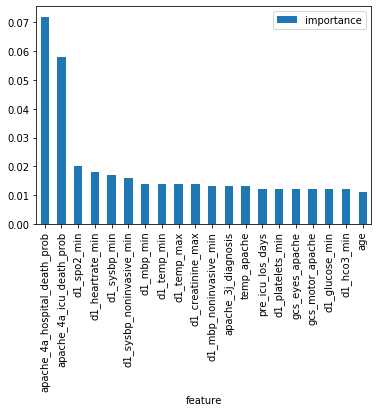

In [94]:
importances.head(20).plot.bar();

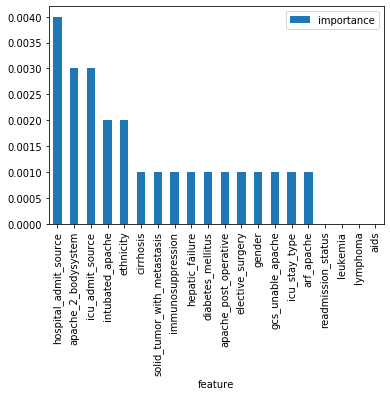

In [95]:
importances[-20:].plot.bar();

**Remarks:**  
aids, leukemia, lymptona and readmission status seems to not play a significant role in our random forest classifiers prediction process. 
Let's investigate more and see what we could keep and what we should drop.

In [96]:
importances[importances['importance'] > 0.01].count()

importance    32
dtype: int64

Let's test:
- We will start with : 31 features => 

In [97]:
importances.index[:31]

Index(['apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob',
       'd1_spo2_min', 'd1_heartrate_min', 'd1_sysbp_min',
       'd1_sysbp_noninvasive_min', 'd1_mbp_min', 'd1_temp_min', 'd1_temp_max',
       'd1_creatinine_max', 'd1_mbp_noninvasive_min', 'apache_3j_diagnosis',
       'temp_apache', 'pre_icu_los_days', 'd1_platelets_min',
       'gcs_eyes_apache', 'gcs_motor_apache', 'd1_glucose_min', 'd1_hco3_min',
       'age', 'heart_rate_apache', 'd1_resprate_min', 'd1_wbc_min',
       'map_apache', 'bmi', 'gcs_verbal_apache', 'd1_hco3_max',
       'd1_heartrate_max', 'd1_platelets_max', 'weight', 'd1_bun_min'],
      dtype='object', name='feature')

In [98]:
imp_31_feat = importances.index[:31]
imp_31_feat.values

array(['apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob',
       'd1_spo2_min', 'd1_heartrate_min', 'd1_sysbp_min',
       'd1_sysbp_noninvasive_min', 'd1_mbp_min', 'd1_temp_min',
       'd1_temp_max', 'd1_creatinine_max', 'd1_mbp_noninvasive_min',
       'apache_3j_diagnosis', 'temp_apache', 'pre_icu_los_days',
       'd1_platelets_min', 'gcs_eyes_apache', 'gcs_motor_apache',
       'd1_glucose_min', 'd1_hco3_min', 'age', 'heart_rate_apache',
       'd1_resprate_min', 'd1_wbc_min', 'map_apache', 'bmi',
       'gcs_verbal_apache', 'd1_hco3_max', 'd1_heartrate_max',
       'd1_platelets_max', 'weight', 'd1_bun_min'], dtype=object)

In [99]:
train_df_t  = train_df[imp_31_feat.values]
train_df_t['hospital_death'] = train_df['hospital_death']
test_df_t  = test_df[imp_31_feat.values]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [146]:
imp_50_feat = importances.index[:50]
train_df_t  = train_df[imp_50_feat.values]
train_df_t['hospital_death'] = train_df['hospital_death']
test_df_t  = test_df[imp_50_feat.values]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [165]:
imp_20_feat = importances.index[:21]
train_df_t  = train_df[imp_20_feat.values]
train_df_t['hospital_death'] = train_df['hospital_death']
test_df_t  = test_df[imp_20_feat.values]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [166]:
train_df_t.head()

,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,d1_spo2_min,d1_heartrate_min,d1_sysbp_min,d1_sysbp_noninvasive_min,d1_mbp_min,d1_temp_min,d1_temp_max,d1_creatinine_max,d1_mbp_noninvasive_min,apache_3j_diagnosis,temp_apache,pre_icu_los_days,d1_platelets_min,gcs_eyes_apache,gcs_motor_apache,d1_glucose_min,d1_hco3_min,age,heart_rate_apache,hospital_death
0,0.100000,0.050000,74.0,72.0,73.0,73.0,46.0,37.2,39.9,2.51000,46.0,502.01,39.3,0.541667,233.000000,3.000000,6.000000,109.00000,15.000000,68,118.0,0
1,0.470000,0.290000,70.0,72.0,67.0,67.0,38.0,35.1,36.3,0.71000,38.0,203.01,35.1,0.927778,487.000000,1.000000,3.000000,128.00000,26.000000,77,120.0,0
2,0.000000,0.000000,91.0,68.0,105.0,105.0,68.0,36.7,37.0,1.48865,68.0,703.03,36.7,0.000694,196.769779,3.000000,6.000000,114.38094,23.170486,25,102.0,0
3,0.040000,0.030000,95.0,92.0,84.0,84.0,84.0,34.8,38.0,1.48865,84.0,1206.03,34.8,0.000694,43.000000,4.000000,6.000000,88.00000,23.170486,81,114.0,0
4,0.086787,0.043955,96.0,60.0,120.0,120.0,90.0,36.7,37.2,1.48865,90.0,601.01,36.7,0.073611,196.769779,3.465049,5.471195,114.38094,23.170486,19,60.0,0


In [0]:
X_train = train_df_t.drop('hospital_death', axis=1)
Y_train = train_df_t["hospital_death"]
X_test = test_df_t

**Training random forest again:**

In [168]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100, oob_score = True)
random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print(round(acc_random_forest,2,), "%")

100.0 %


Our random forest model predicts as good as it did before. A general rule is that, **the more features you have, the more likely your model will suffer from overfitting** and vice versa. But I think our data looks fine for now and hasn't too much features.

There is also another way to evaluate a random-forest classifier, which is probably much more accurate than the score we used before. What I am talking about is the out-of-bag samples to estimate the generalization accuracy. I will not go into details here about how it works. Just note that **out-of-bag estimate is as accurate as using a test set of the same size as the training set**. Therefore, using the out-of-bag error estimate *removes the need for a set aside test set*.

In [169]:
print("oob score:", round(random_forest.oob_score_, 4)*100, "%")

oob score: 92.7 %


Now we can start tuning the hyperameters of random forest.

## Hyperparameter Tuning

Below you can see the code of the hyperparamter tuning for the parameters criterion, min_samples_leaf, min_samples_split and n_estimators.

I put this code into a markdown cell and not into a code cell, because it takes a long time to run it. Directly underneeth it, I put a screenshot of the gridsearch's output.



```
param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_leaf": [1, 5, 10, 25, 50, 70],
              "min_samples_split": [2, 4, 10, 12, 16, 18, 25, 35],
              "n_estimators": [100, 400, 700, 1000, 1500]}

from sklearn.model_selection import GridSearchCV, cross_val_score

rf = RandomForestClassifier(n_estimators=100,
                            max_features='auto',
                            oob_score=True,
                            random_state=1,
                            n_jobs=-1)

clf = GridSearchCV(estimator=rf,
                   param_grid=param_grid,
                   n_jobs=-1)

clf.fit(X_train, Y_train)

clf.bestparams
```



In [115]:
param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_leaf": [1, 5, 10],
              "min_samples_split": [2, 4, 10],
              "n_estimators": [100, 200]}

from sklearn.model_selection import GridSearchCV, cross_val_score

rf = RandomForestClassifier(n_estimators=100,
                            max_features='auto',
                            oob_score=True,
                            random_state=1,
                            n_jobs=1)

clf = GridSearchCV(estimator=rf,
                   param_grid=param_grid,
                   n_jobs=1,
                   verbose=1)

clf.fit(X_train, Y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 104.1min finished


AttributeError: ignored

In [118]:
import sklearn
sklearn.__version__

'0.22.1'

In [119]:
clf.best_params_

{'criterion': 'gini',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 200}

**Best**:  

{'criterion': 'gini',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 200}

## Test new Parameters

In [170]:
# Random Forest
random_forest = RandomForestClassifier(criterion = "gini", 
                                       min_samples_leaf = 1, 
                                       min_samples_split = 4,   
                                       n_estimators=200, 
                                       max_features='auto', 
                                       oob_score=True, 
                                       random_state=1, 
                                       n_jobs=-1)

random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

print("oob score:", round(random_forest.oob_score_, 4)*100, "%")

oob score: 92.81 %


Now that we have a proper model, we can start evaluating it’s performace in a more accurate way. Previously we only used accuracy and the oob score, which is just another form of accuracy. The problem is just, that it’s more complicated to evaluate a classification model than a regression model. We will talk about this in the following section.

## Further Evaluation

### Confusion Matrix

In [0]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

predictions = cross_val_predict(random_forest, X_train, Y_train, cv=3)
confusion_matrix = confusion_matrix(Y_train, predictions)

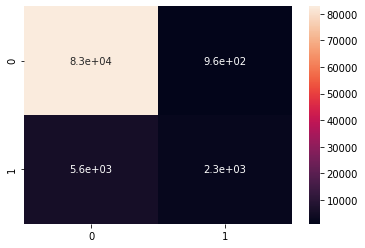

In [172]:
import seaborn as sn
sn.heatmap(confusion_matrix, annot=True)

In [173]:
confusion_matrix

array([[82840,   958],
       [ 5645,  2270]])

The first row is about the not-death-predictions: 82826 patient were correctly classified as not-death (called true negatives) and 972 where wrongly classified as not-death (false positives).

The second row is about the death-predictions: 5636 patient where wrongly classified as death (false negatives) and 2279 where correctly classified as death (true positives).

A confusion matrix gives you a lot of information about how well your model does, but theres a way to get even more, like computing the classifiers precision.

## Precision and Recall

In [174]:
from sklearn.metrics import precision_score, recall_score

print("Precision:", precision_score(Y_train, predictions))
print("Recall:", recall_score(Y_train, predictions))

Precision: 0.7032218091697645
Recall: 0.28679722046746686


Our model predicts 70% of the time, a patient death correctly (precision). The recall tells us that it predicted the death of 29 % of the people who actually survived.

## F-Score

You can combine precision and recall into one score, which is called the F-score. The F-score is computed with the harmonic mean of precision and recall. Note that it assigns much more weight to low values. As a result of that, the classifier will only get a high F-score, if both recall and precision are high.

In [175]:
from sklearn.metrics import f1_score

f1_score(Y_train, predictions)

0.4074306739657184

There we have it, a 41% F-score. The score is too low, because we have a recall of 29%. But unfortunately the F-score is not perfect, because it favors classifiers that have a similar precision and recall. This is a problem, because you sometimes want a high precision and sometimes a high recall. The thing is that an increasing precision, sometimes results in an decreasing recall and vice versa (depending on the threshold). This is called the precision/recall tradeoff. We will discuss this in the following section.

## ROC AUC Curve
Another way to evaluate and compare your binary classifier is provided by the ROC AUC Curve. This curve plots the true positive rate (also called recall) against the false positive rate (ratio of incorrectly classified negative instances), instead of plotting the precision versus the recall.

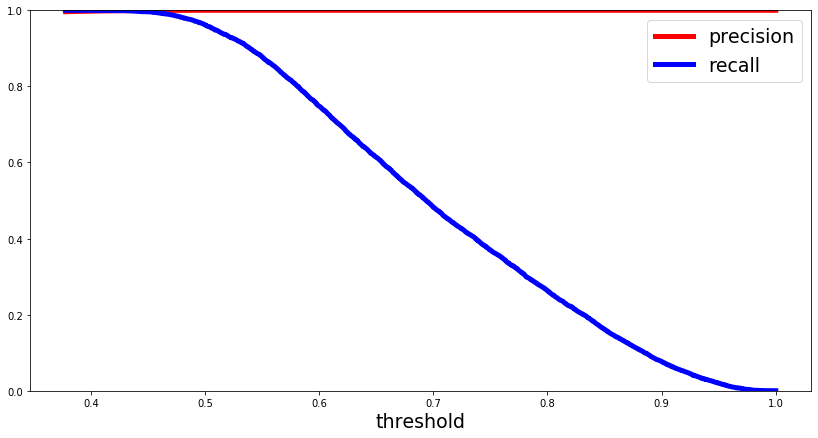

In [176]:
from sklearn.metrics import precision_recall_curve

# getting the probabilities of our predictions
y_scores = random_forest.predict_proba(X_train)
y_scores = y_scores[:, 1]

precision, recall, threshold = precision_recall_curve(Y_train, y_scores)

def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision",
            linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall",
            linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])
    
plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

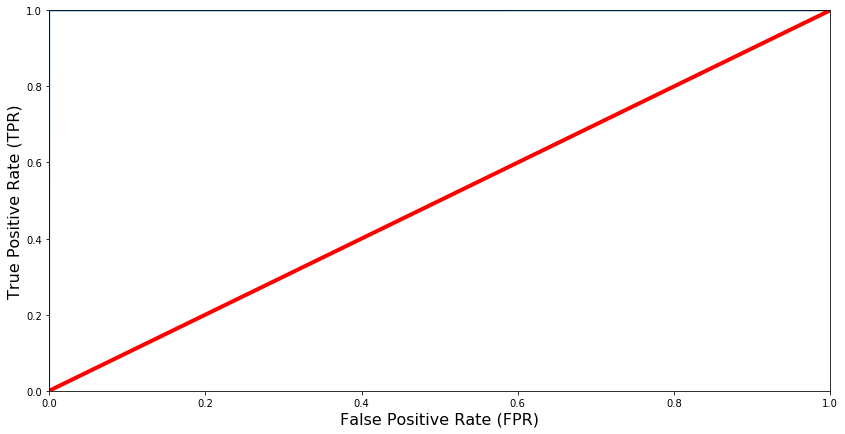

In [177]:
from sklearn.metrics import roc_curve
# compute true positive rate and false positive rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_train, y_scores)
# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

The red line in the middel represents a purely random classifier (e.g a coin flip) and therefore your classifier should be as far away from it as possible. Our Random Forest model seems to do a good job.

Of course we also have a tradeoff here, because the classifier produces more false positives, the higher the true positive rate is.

## ROC AUC Score
The ROC AUC Score is the corresponding score to the ROC AUC Curve. It is simply computed by measuring the area under the curve, which is called AUC.
A classifiers that is 100% correct, would have a ROC AUC Score of 1 and a completely random classiffier would have a score of 0.5.

In [178]:
from sklearn.metrics import roc_auc_score

r_a_score = roc_auc_score(Y_train, y_scores)
print("ROC-AUC-Score:", r_a_score)

ROC-AUC-Score: 0.9999990320555023


## Predictions and submission to kaggle

In [0]:
predictions = Y_prediction

In [161]:
!cat samplesubmission.csv

encounter_id,hospital_death
2,0.5
5,0.2
7,0.001


In [138]:
test_df.head()

,encounter_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,resprate_apache,sodium_apache,temp_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,...,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,2,NaN,68,21.102439,0,0,0,180.300000,1,1,1105,0,3,0.104167,0,68.6,301.0,405.01,0,0.0,19.000000,0.670000,2.0,5.0,0.0,1.0,276.000000,105.0,42.00000,0.0,57.0,5.0,134.000000,36.6,0.0,4.700000,74.0,51.0,74.000000,51.00000,...,91.000000,79.000000,91.000000,79.000000,36.600000,36.600000,19.0,19.0,9.3,9.3,0.67,0.67,276.0,167.0,24.000000,24.000000,13.8,13.8,42.0,42.0,223.0,223.0,4.8,4.8,135.0,134.0,4.7,4.7,0.13,0.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,1
1,5,NaN,77,19.500595,1,0,1,145.000000,2,2,1043,0,1,0.230556,0,41.0,217.0,1502.02,1,0.0,25.476898,1.485251,4.0,6.0,0.0,4.0,159.696647,60.0,32.94664,0.0,53.0,37.0,137.898008,37.0,0.0,12.310268,65.0,31.0,65.000000,31.00000,...,121.000000,96.000000,121.000000,96.000000,36.600000,36.600000,12.0,12.0,8.0,8.0,0.60,0.60,100.0,100.0,31.000000,31.000000,9.9,9.9,30.9,30.9,93.0,93.0,4.4,4.4,140.0,140.0,3.0,3.0,0.09,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,1
2,7,NaN,25,32.518596,1,2,0,170.200000,2,2,1035,0,2,0.140972,0,94.2,302.0,1208.06,1,0.0,22.000000,1.840000,2.0,5.0,0.0,1.0,81.000000,124.0,39.20000,0.0,115.0,31.0,130.000000,35.5,0.0,14.800000,85.0,57.0,89.025936,49.16373,...,133.306432,115.043646,133.072175,115.017824,36.749211,36.628501,22.0,19.0,8.7,8.4,1.84,1.63,117.0,81.0,22.000000,19.000000,12.7,12.2,40.9,39.2,184.0,181.0,4.7,4.5,135.0,130.0,14.8,10.0,0.03,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0
3,8,NaN,81,20.798520,0,0,0,182.800000,2,2,1078,0,1,0.002083,0,69.5,303.0,211.03,0,0.0,24.000000,0.750000,4.0,6.0,0.0,1.0,122.000000,111.0,32.00000,1.0,48.0,30.0,133.000000,37.7,1.0,9.700000,63.0,42.0,63.000000,42.00000,...,115.000000,92.000000,115.000000,92.000000,38.000000,38.000000,24.0,24.0,7.9,7.4,0.75,0.72,148.0,122.0,22.000000,20.000000,11.0,9.1,32.0,27.0,248.0,209.0,4.1,4.0,138.0,133.0,9.7,7.1,0.19,0.17,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,2
4,10,NaN,19,28.947566,0,0,0,169.518118,1,1,1012,0,3,0.004861,0,66.4,217.0,1501.01,1,0.0,11.000000,0.520000,1.0,4.0,0.0,1.0,192.000000,94.0,32.80000,0.0,41.0,5.0,134.000000,36.1,1.0,14.500000,100.0,24.0,100.000000,24.00000,...,222.000000,194.000000,222.000000,195.000000,36.000000,36.000000,11.0,9.0,8.2,7.7,0.67,0.52,192.0,141.0,24.650889,23.245647,12.3,11.1,36.5,32.8,223.0,218.0,4.2,3.5,150.0,134.0,14.5,14.1,0.50,0.42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,1


In [0]:
submissions = pd.DataFrame({"encounter_id": test_df['encounter_id'],
    "hospital_death": predictions})
submissions.to_csv("my_submission3.csv", index=False, header=True)

In [140]:
submissions.head()

,encounter_id,hospital_death
0,2,0
1,5,0
2,7,0
3,8,0
4,10,0


In [182]:
# submit the file to kaggle
!kaggle competitions submit -c widsdatathon2020 -f my_submission3.csv -m "Submit results through Google Colab!"

100% 313k/313k [00:03<00:00, 82.8kB/s]
Successfully submitted to WiDS Datathon 2020

First submission result :  
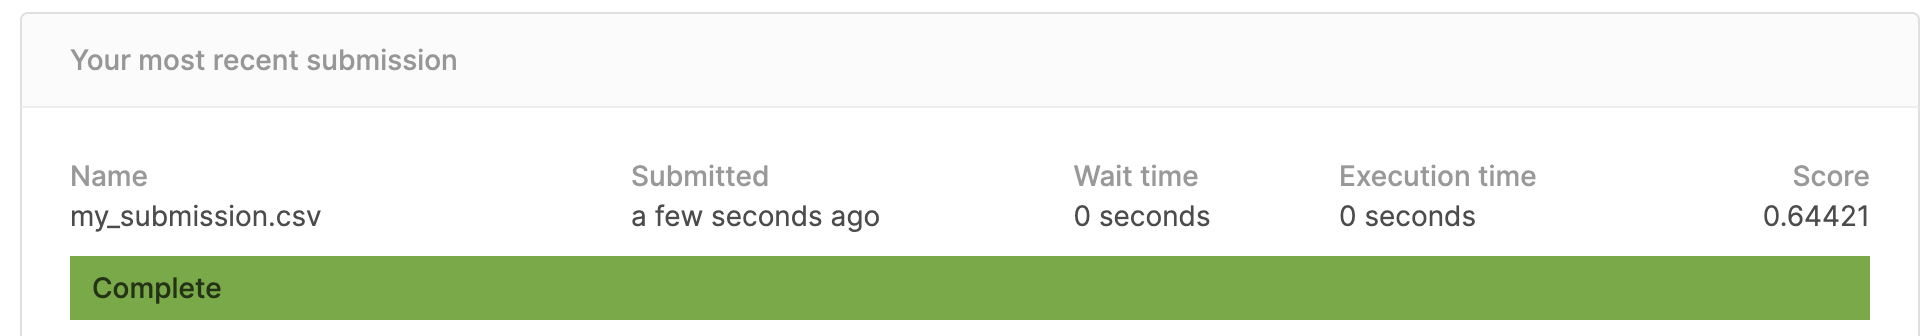

Second submission:
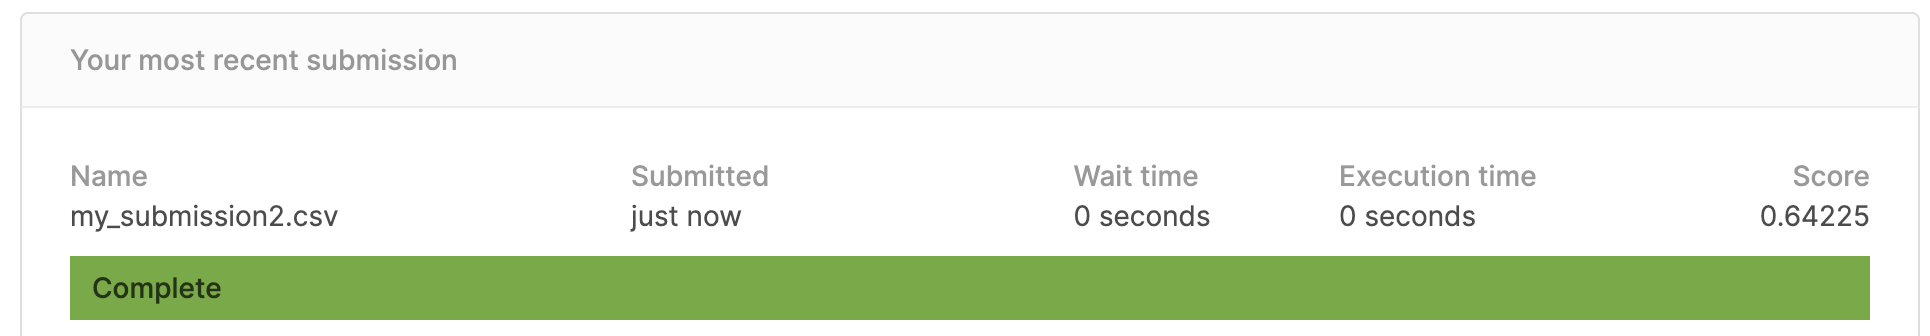

Third submission:
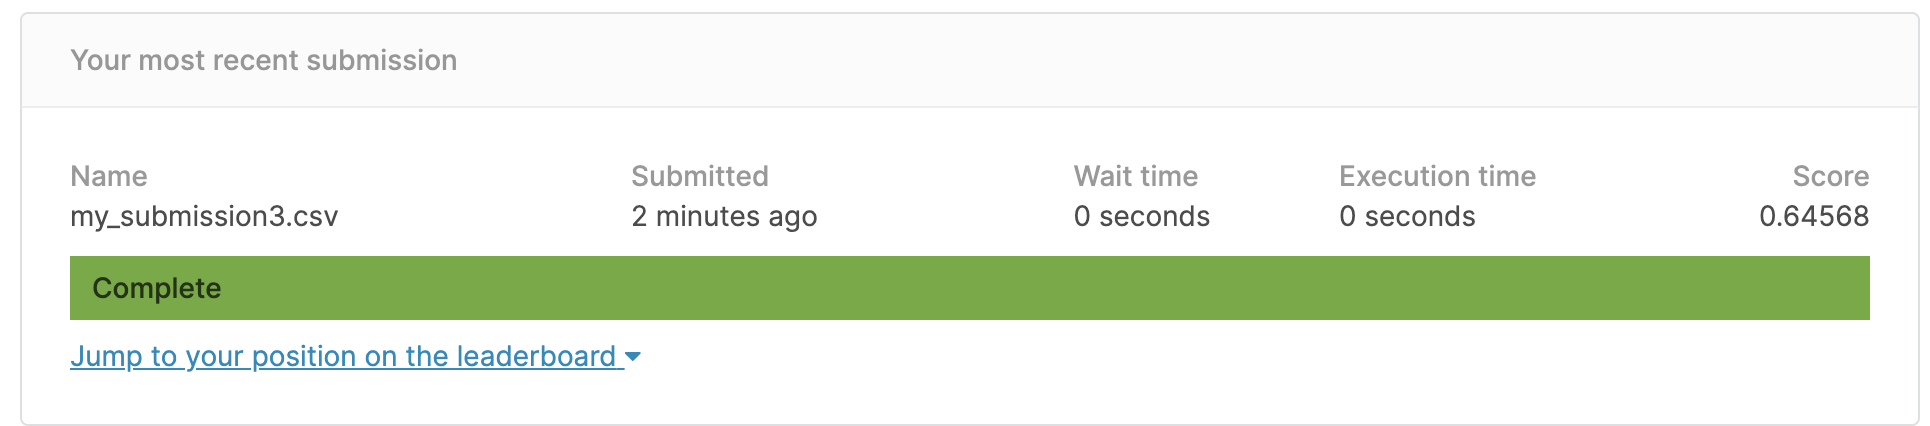